<a href="https://colab.research.google.com/github/Pooret/inspiritai/blob/main/deBERTa_squad_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers sentencepiece

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import DebertaV2TokenizerFast, DebertaV2ForQuestionAnswering
import torch

model_path = "/content/drive/MyDrive/models/fine_tuned_deberta_squad" # your path here
model = DebertaV2ForQuestionAnswering.from_pretrained(model_path)
tokenizer = DebertaV2TokenizerFast.from_pretrained('microsoft/deberta-v3-base')
model_weights = model.state_dict()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
question = "Where did I leave my ball?"
response = "Your ball is on top of the table."


inputs = tokenizer.encode_plus(question, response, return_tensors='pt',  add_special_tokens=True)
outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions

In [ ]:
import numpy as np

# examine the outputs
start_logits = outputs.start_logits
end_logits = outputs.end_logits

# apply softmax
start_probs = torch.softmax(start_logits, dim=-1)
end_probs = torch.softmax(end_logits, dim=-1)

# Find the tokens with the highest start and end probabilities
start_index = torch.argmax(start_probs)
end_index = torch.argmax(end_probs)

# convert indices to tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]) # the context or "response"

# extract the answer tokens and combine them into a string
answer_tokens = tokens[start_index: end_index + 1]
answer = " ".join(answer_tokens)

# Inducer prediction
num_layers = len(attentions)
num_heads = attentions[0].size(1)

question_end_index = tokens.index('[SEP]')
question_indices = range(1, question_end_index)
summed_attentions = np.zeros(len(tokens[:question_end_index]))

# Sum the attentions
for layer in range(num_layers):
    for head in range(num_heads):
        summed_attentions += attentions[layer][0, head, start_index:end_index + 1, :question_end_index].sum(dim=0).detach().numpy()

# Define a set of special tokens we want to exclude
special_tokens = {'[CLS]', '[SEP]', '[PAD]', '[UNK]'}

# Pair tokens with their summed attention, excluding special tokens
token_attention_pairs = [(token, summed_attentions[i]) for i, token in enumerate(tokens[:question_end_index]) if token not in special_tokens]

# Sort by attention, descending
token_attention_pairs.sort(key=lambda x: x[1], reverse=True)

# Since DeBERTa uses SentencePiece, it may have split words into subwords.
# We will have to merge them back together by removing the leading spaces (indicated by "▁") and combining subwords.
answer = answer.replace(' ▁', ' ').replace('▁', '  ').strip()
inducer = token_attention_pairs[0][0].replace(' ▁', ' ').replace('▁', '  ').strip()

# find induction tokens
inducer_tokens = []
for token in token_attention_pairs:
    #if token[0] == '?': # if token is ?, stop here
    inducer_tokens.append(token[0])


# deprocess inducers
inducers = " ".join([token.replace(' ▁', ' ').replace('▁', '  ').strip() for token in inducer_tokens])

print(f"Question: {question}")
print(f"Answer: {answer}")
print(f"Main induction token: {inducer}")
print(f"Induced by: {inducers}")

Question: Where did I leave my ball?
Answer: top of the table
Main induction token: Where
Induced by: Where leave ? ball my I did


In [ ]:
token_attention_pairs

[('▁Where', 26.58583746849763),
 ('▁leave', 17.92149421121576),
 ('?', 13.440385562371375),
 ('▁ball', 5.05597411722556),
 ('▁my', 2.962154329099576),
 ('▁I', 2.1754971473528713),
 ('▁did', 1.9875944194918702)]

## Attention Heatmaps

* Each row in an attention matrix corresponds to a query token. The query
tokens are the tokens for which the model is calculating attention scores to decide how much focus or 'attention' to place on other tokens.
Each column in the matrix corresponds to a key token. These are the tokens that the query tokens are 'looking at' when the model is determining the attention scores.

* The values within the matrix (each cell) represent the attention score from one token to another. A higher value means that the token represented by the row is paying more attention to the token represented by the column.

* When you visualize an attention matrix using a heatmap, you're essentially visualizing how each token (each row) distributes its attention across all other tokens (each column) in the sequence.

For example:  
> If you have a sentence like "The cat sat on the mat", and you are looking at the attention matrix for the token "cat":The row for "cat" will show how much attention "cat" pays to "The", "sat", "on", "the", and "mat".
If the value in the "sat" column is high, it indicates that "cat" is strongly associated with "sat" in this particular attention pattern.

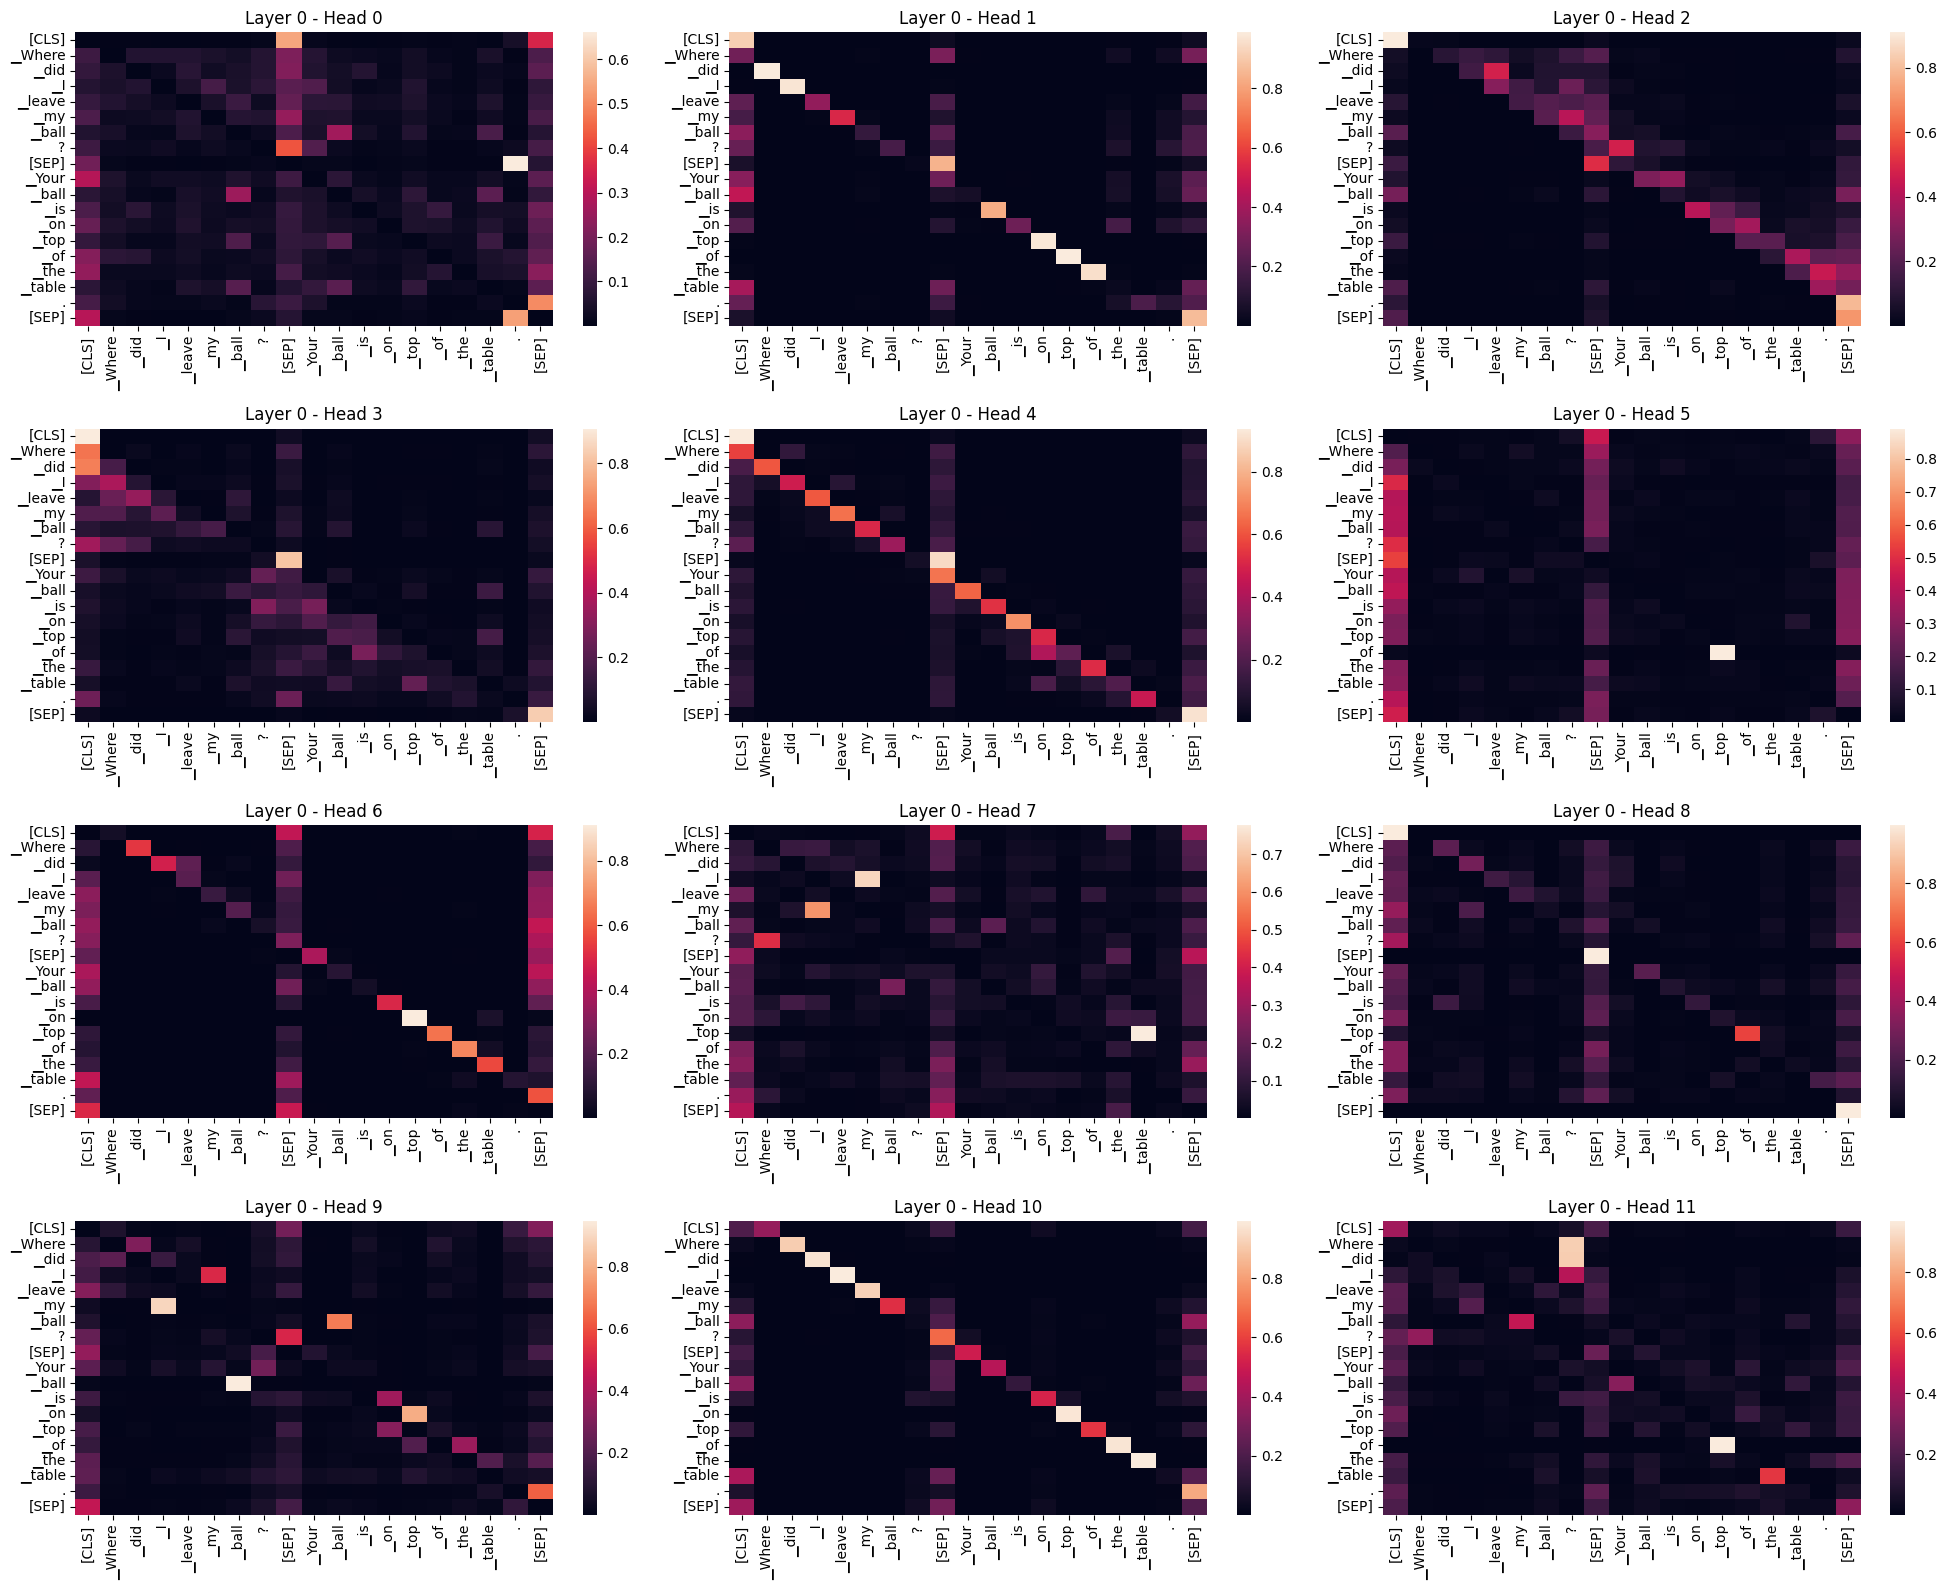

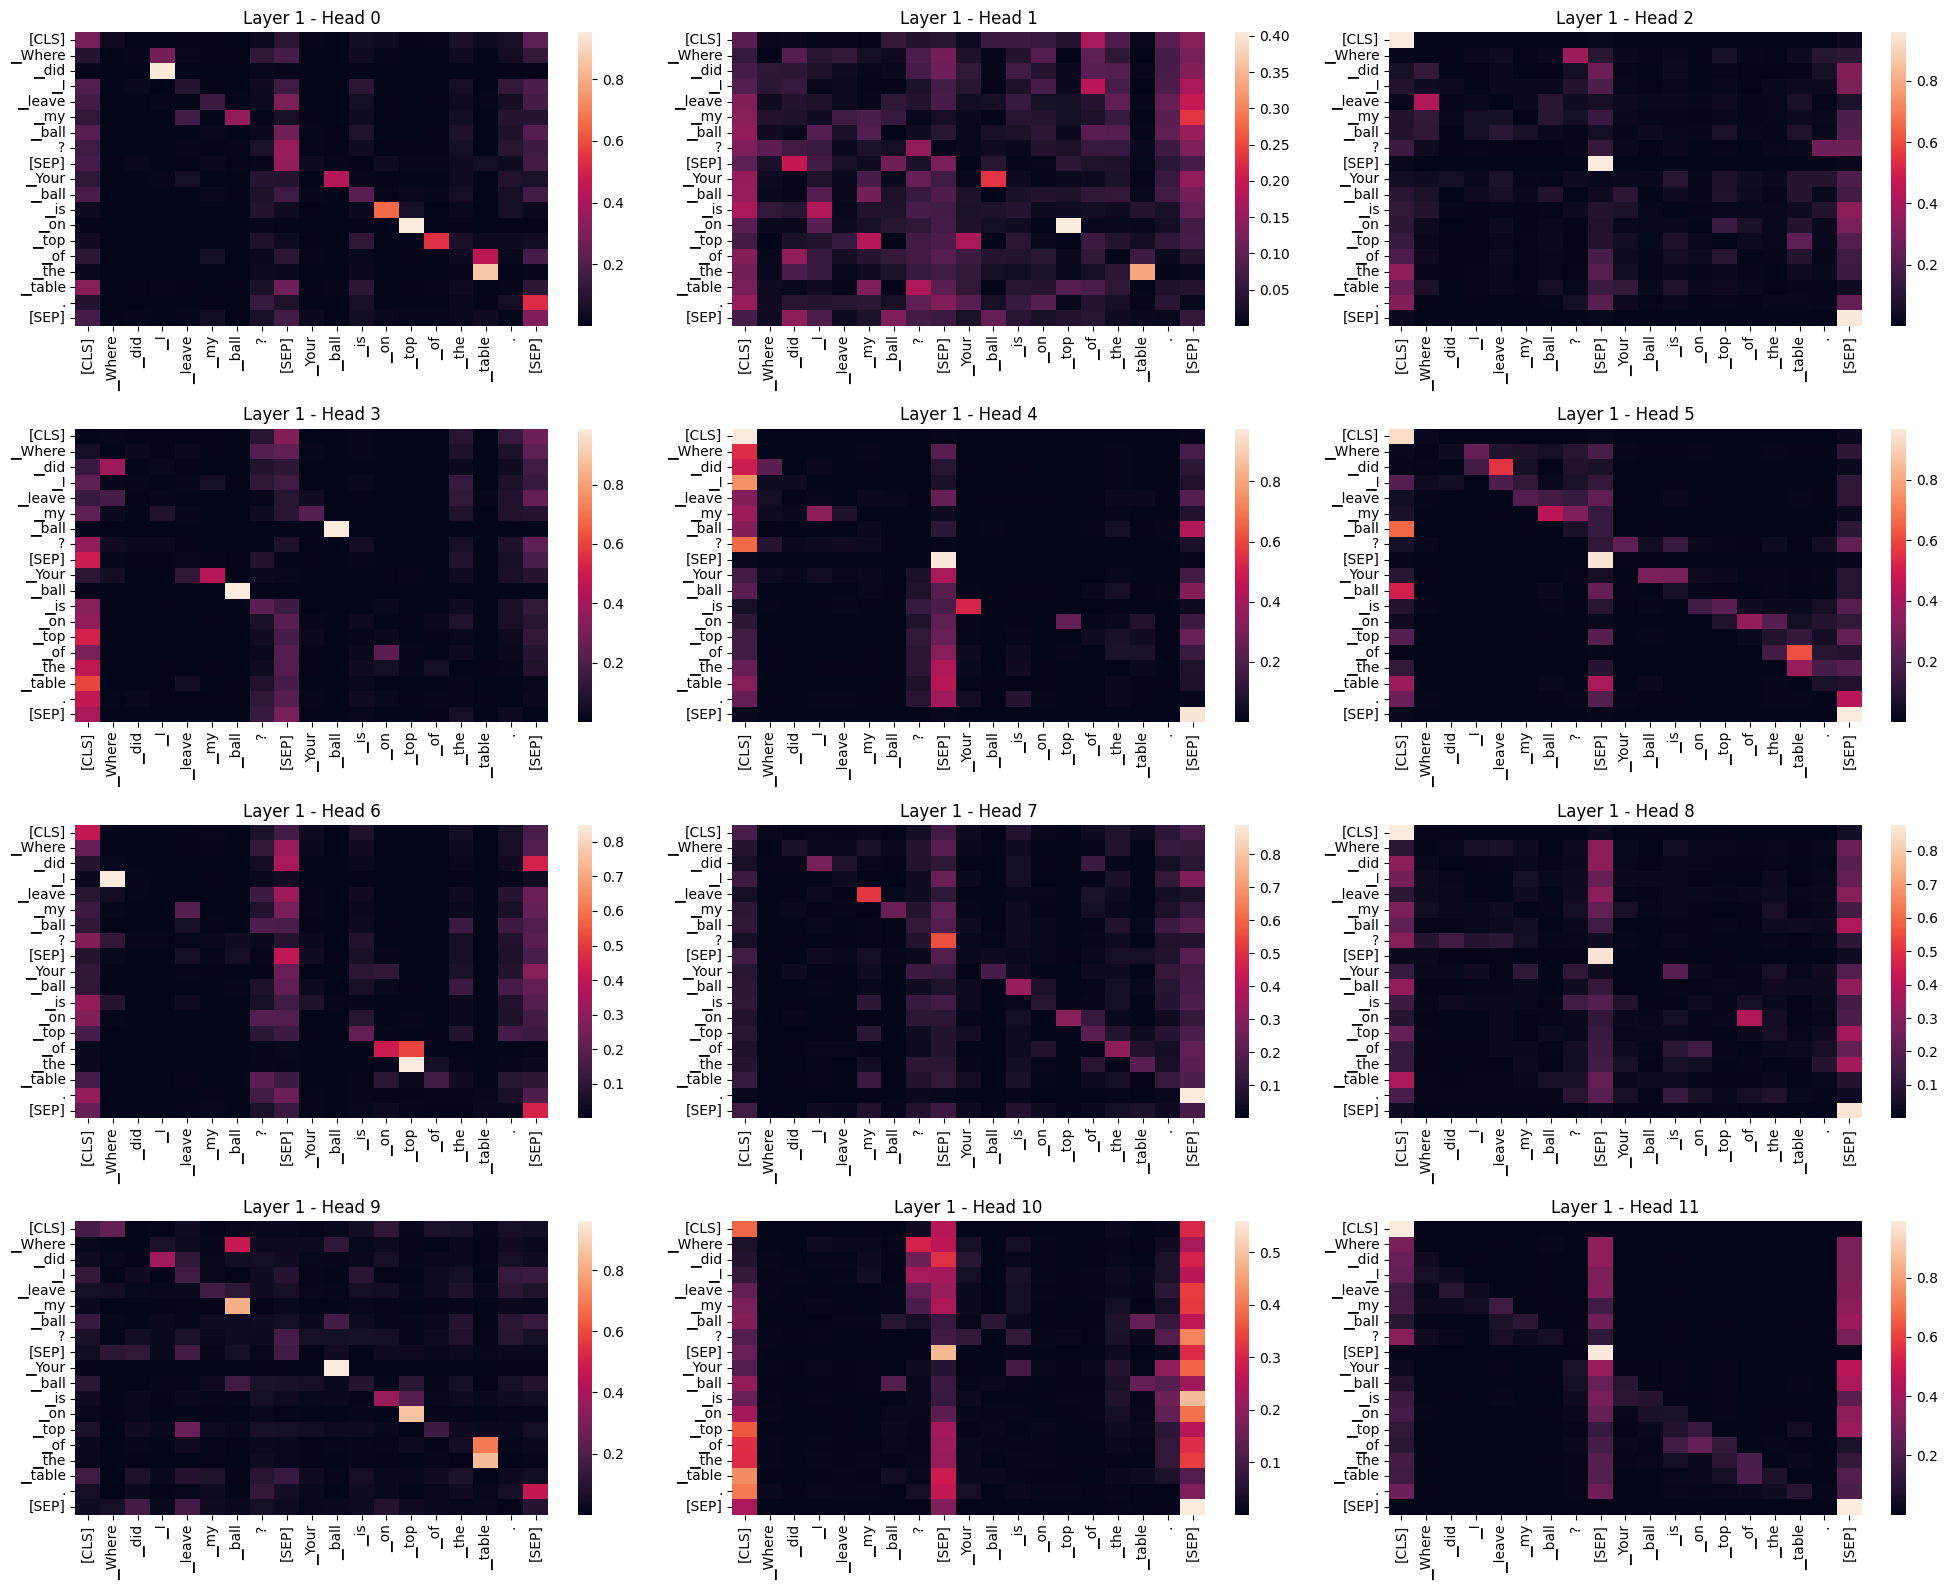

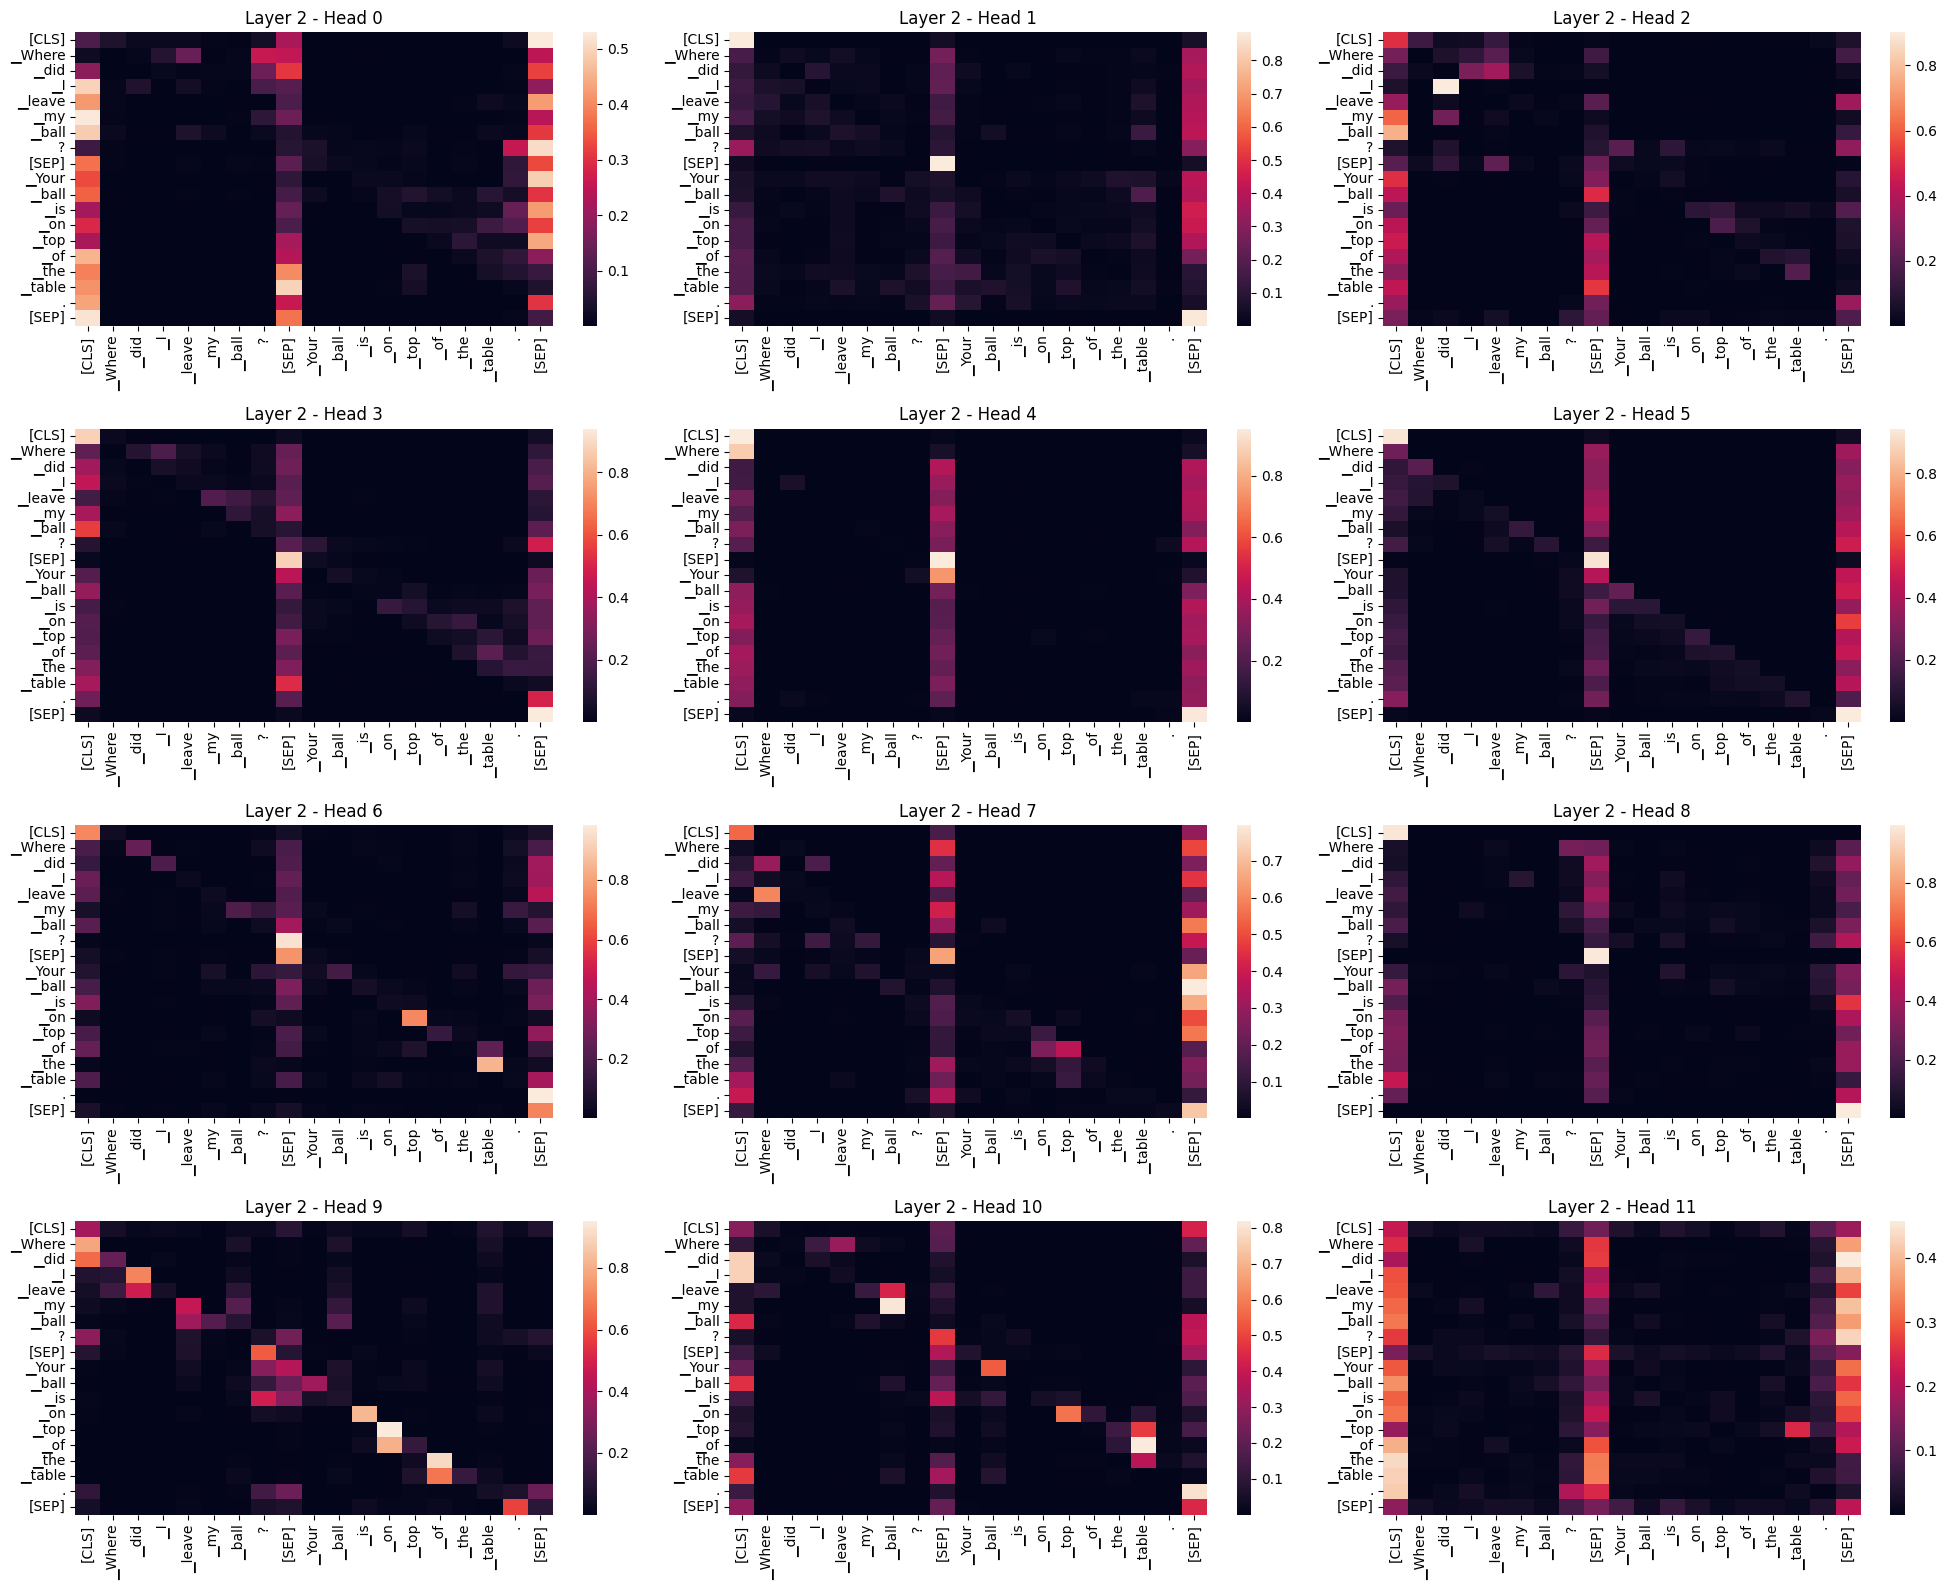

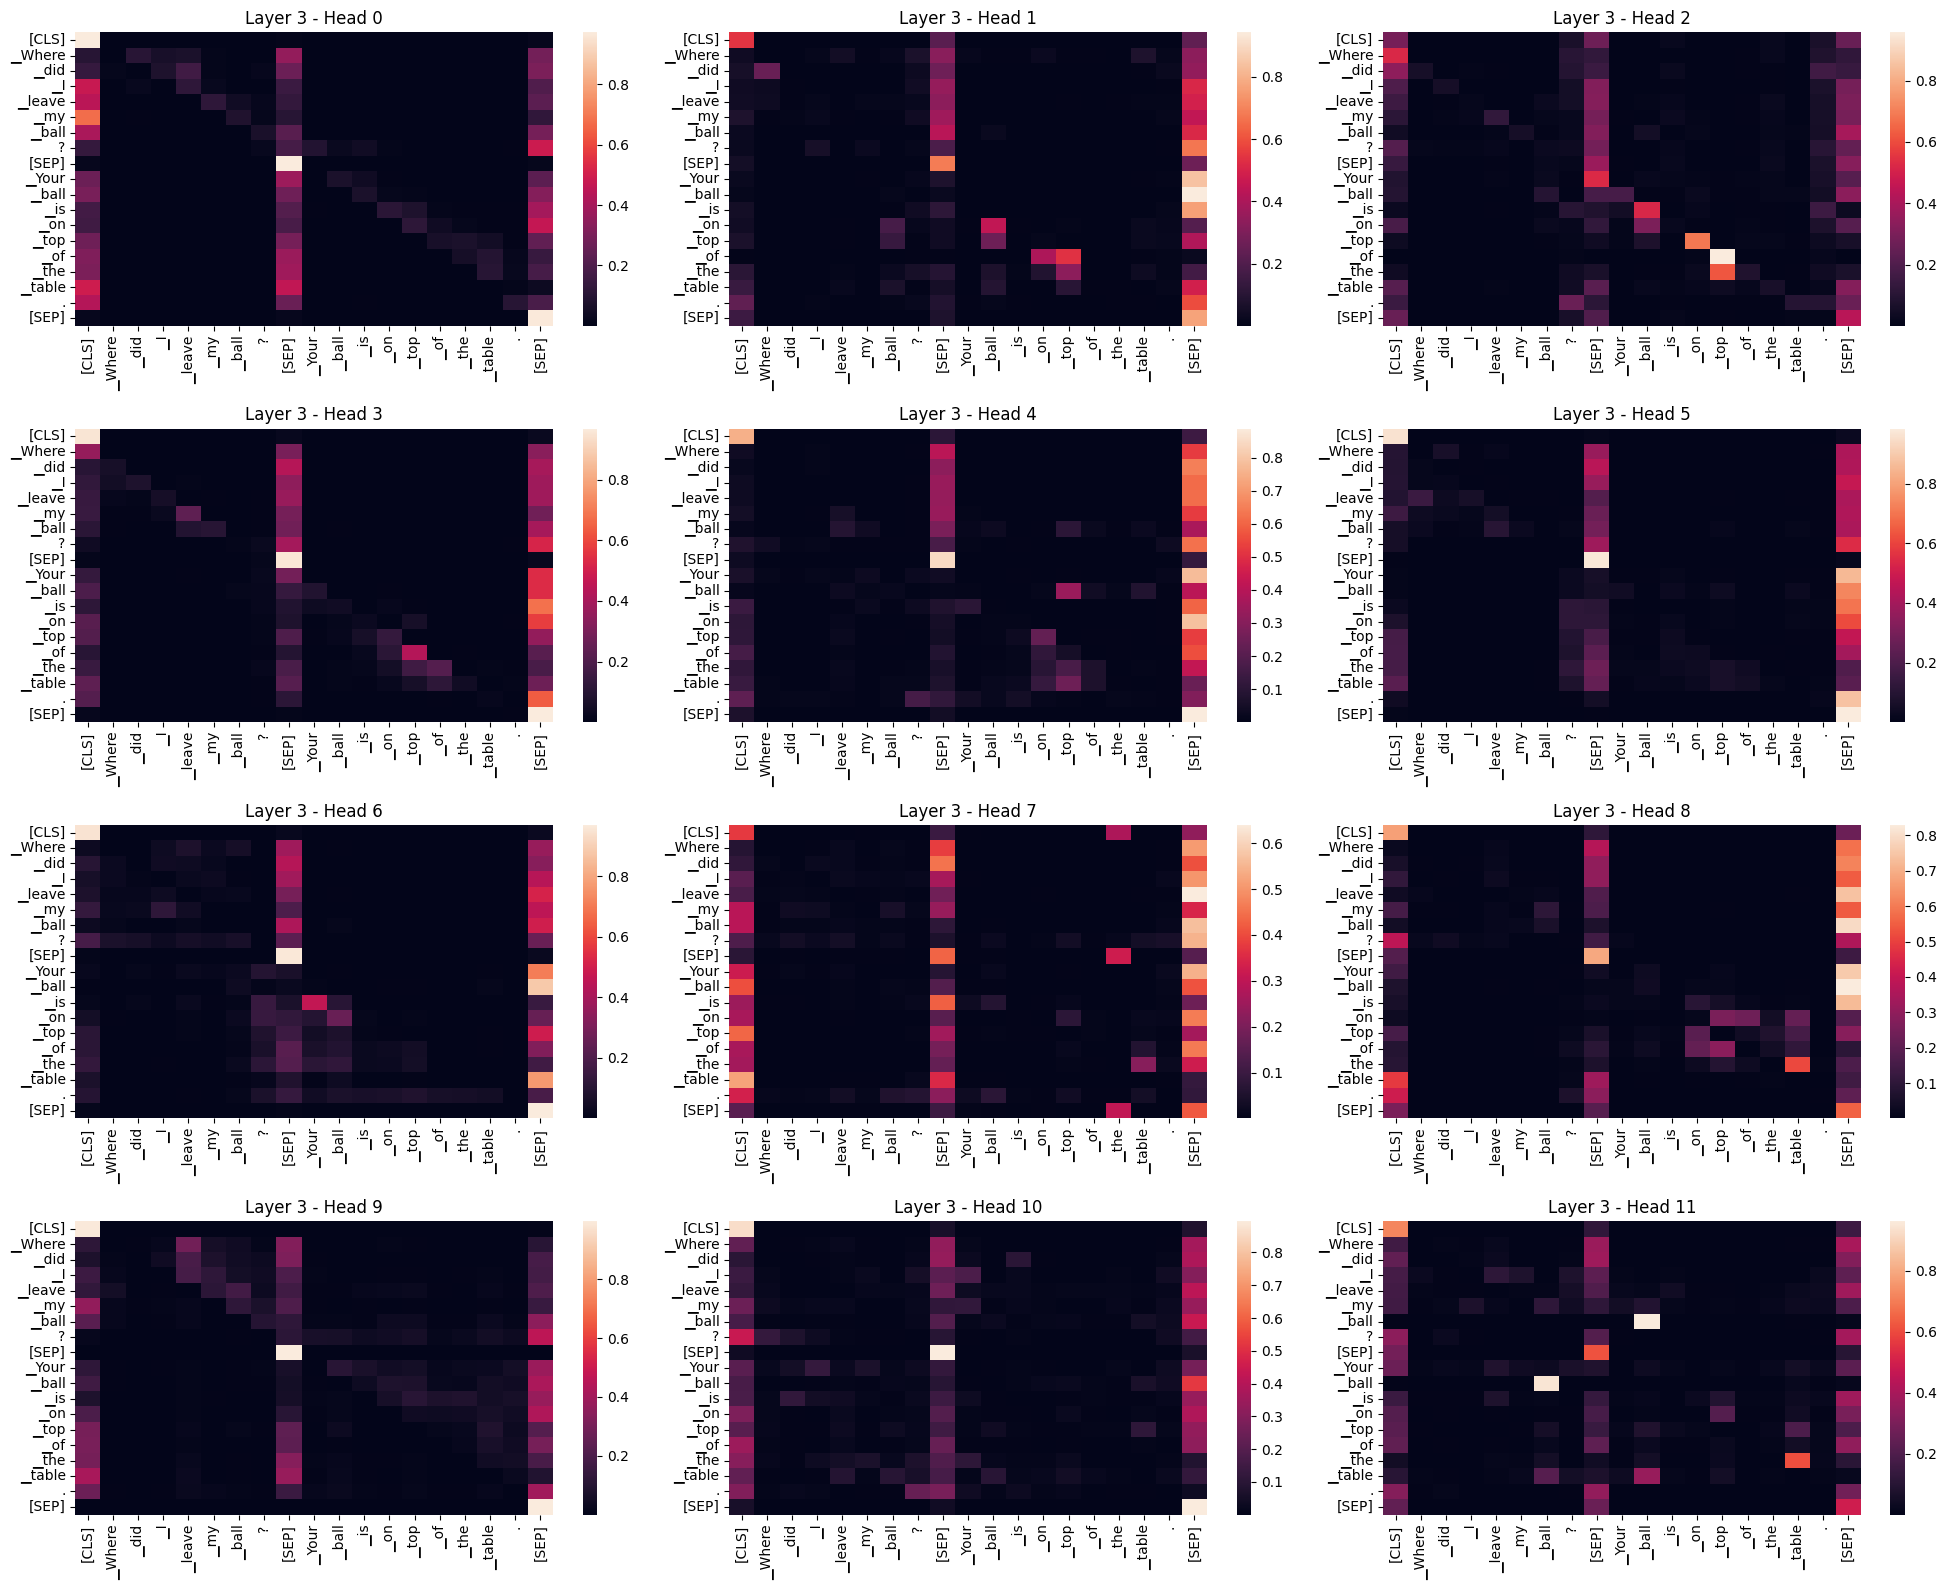

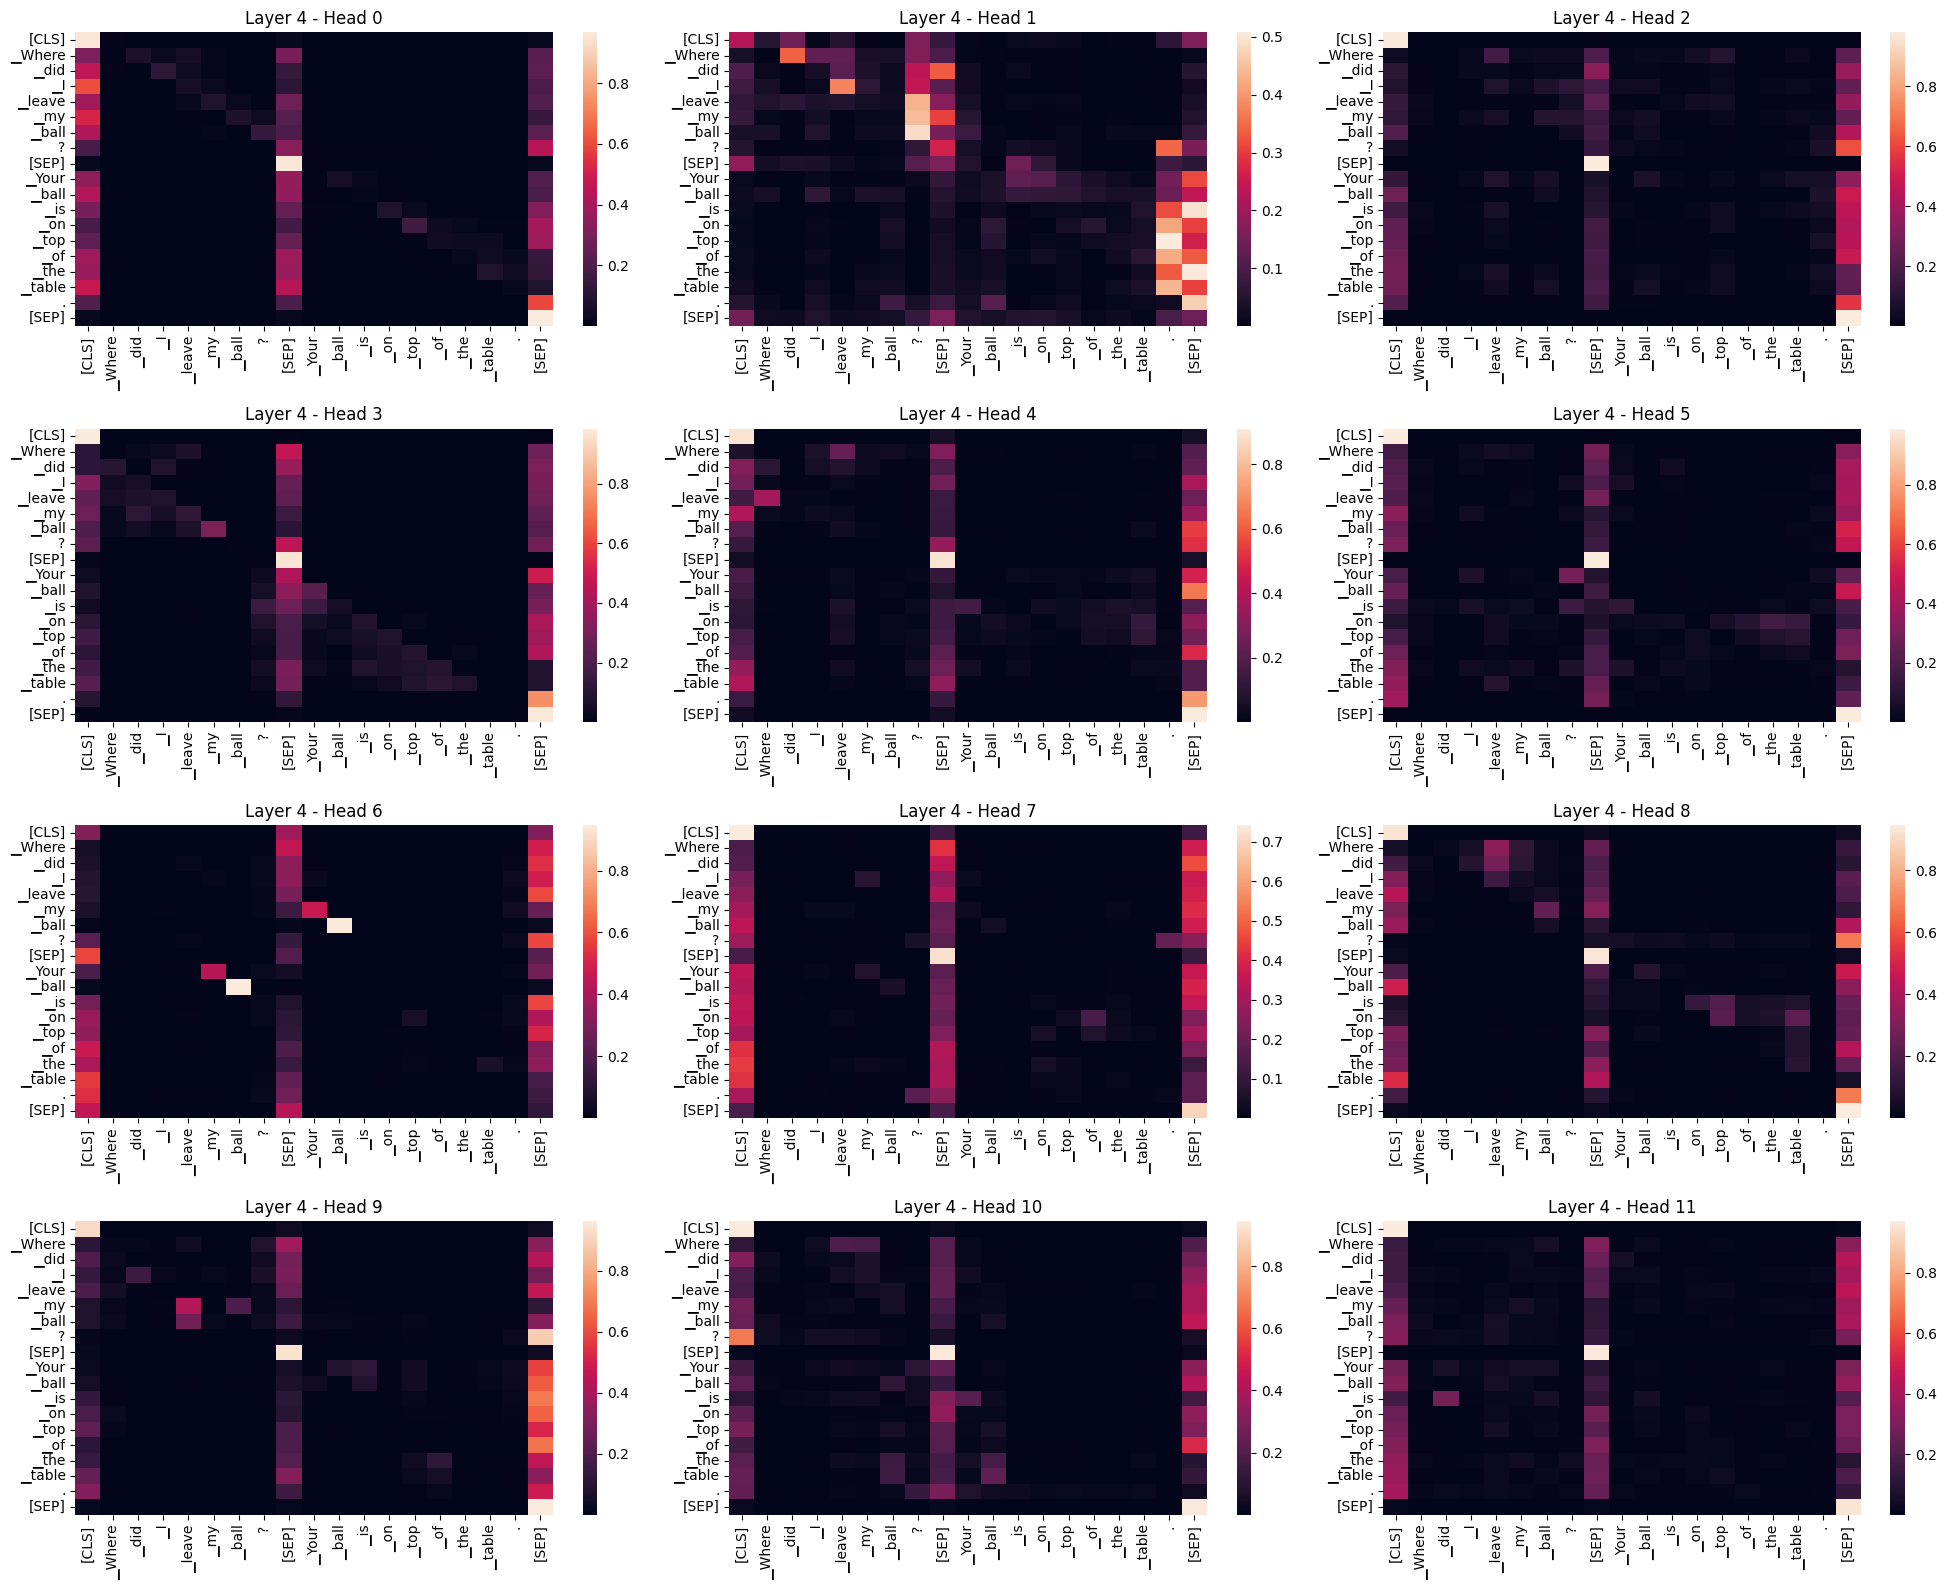

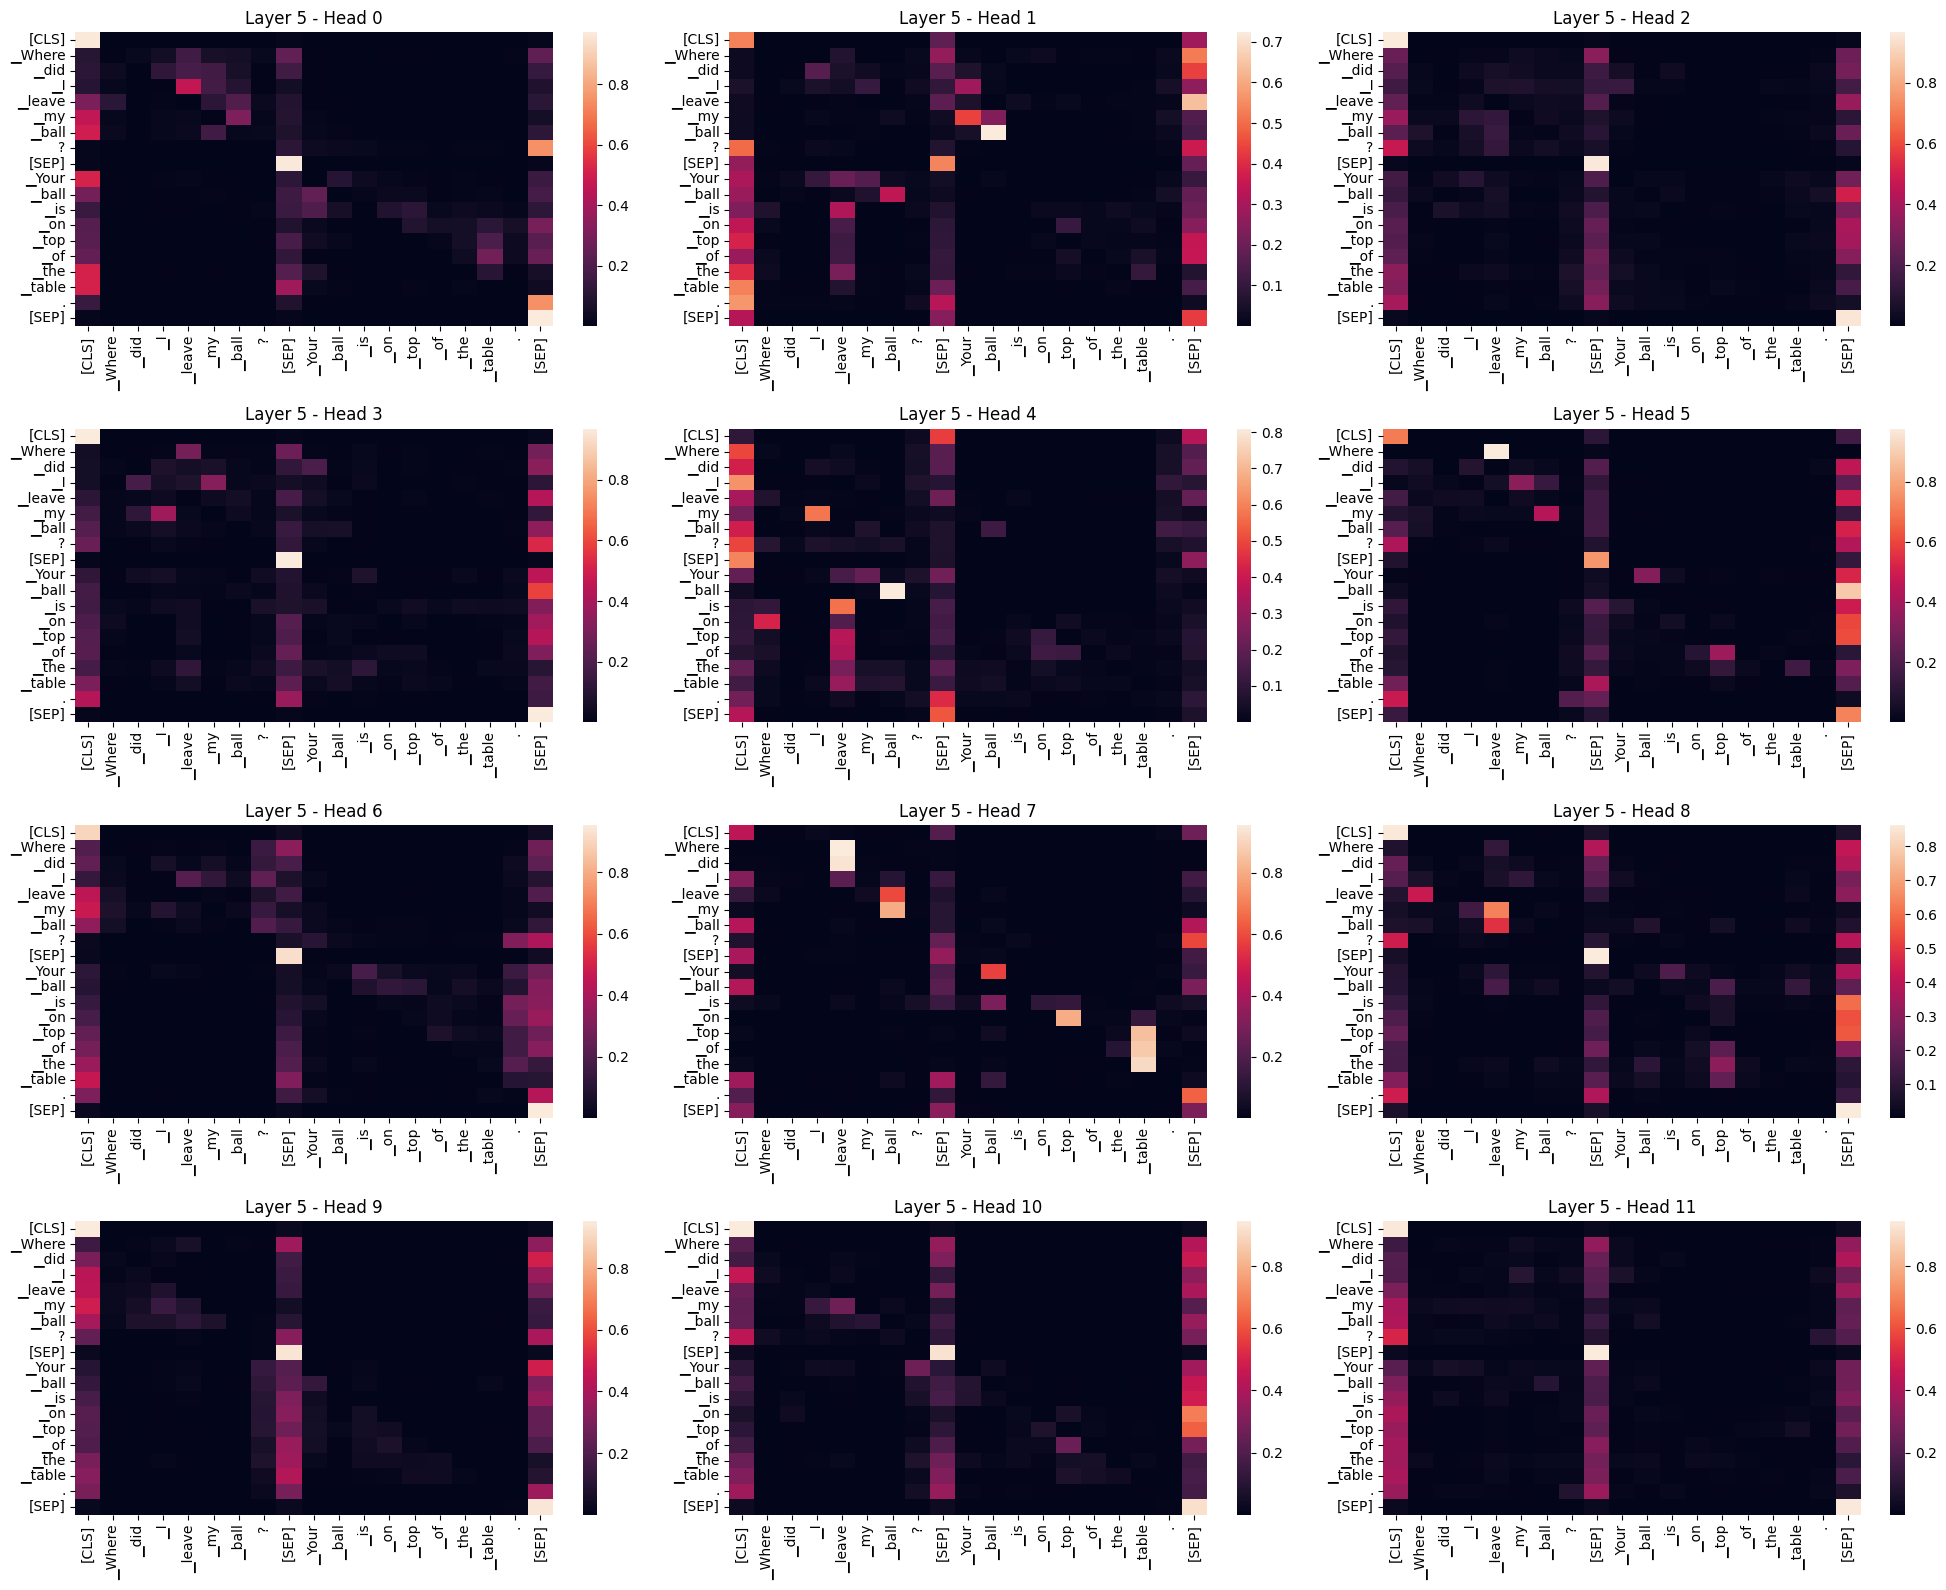

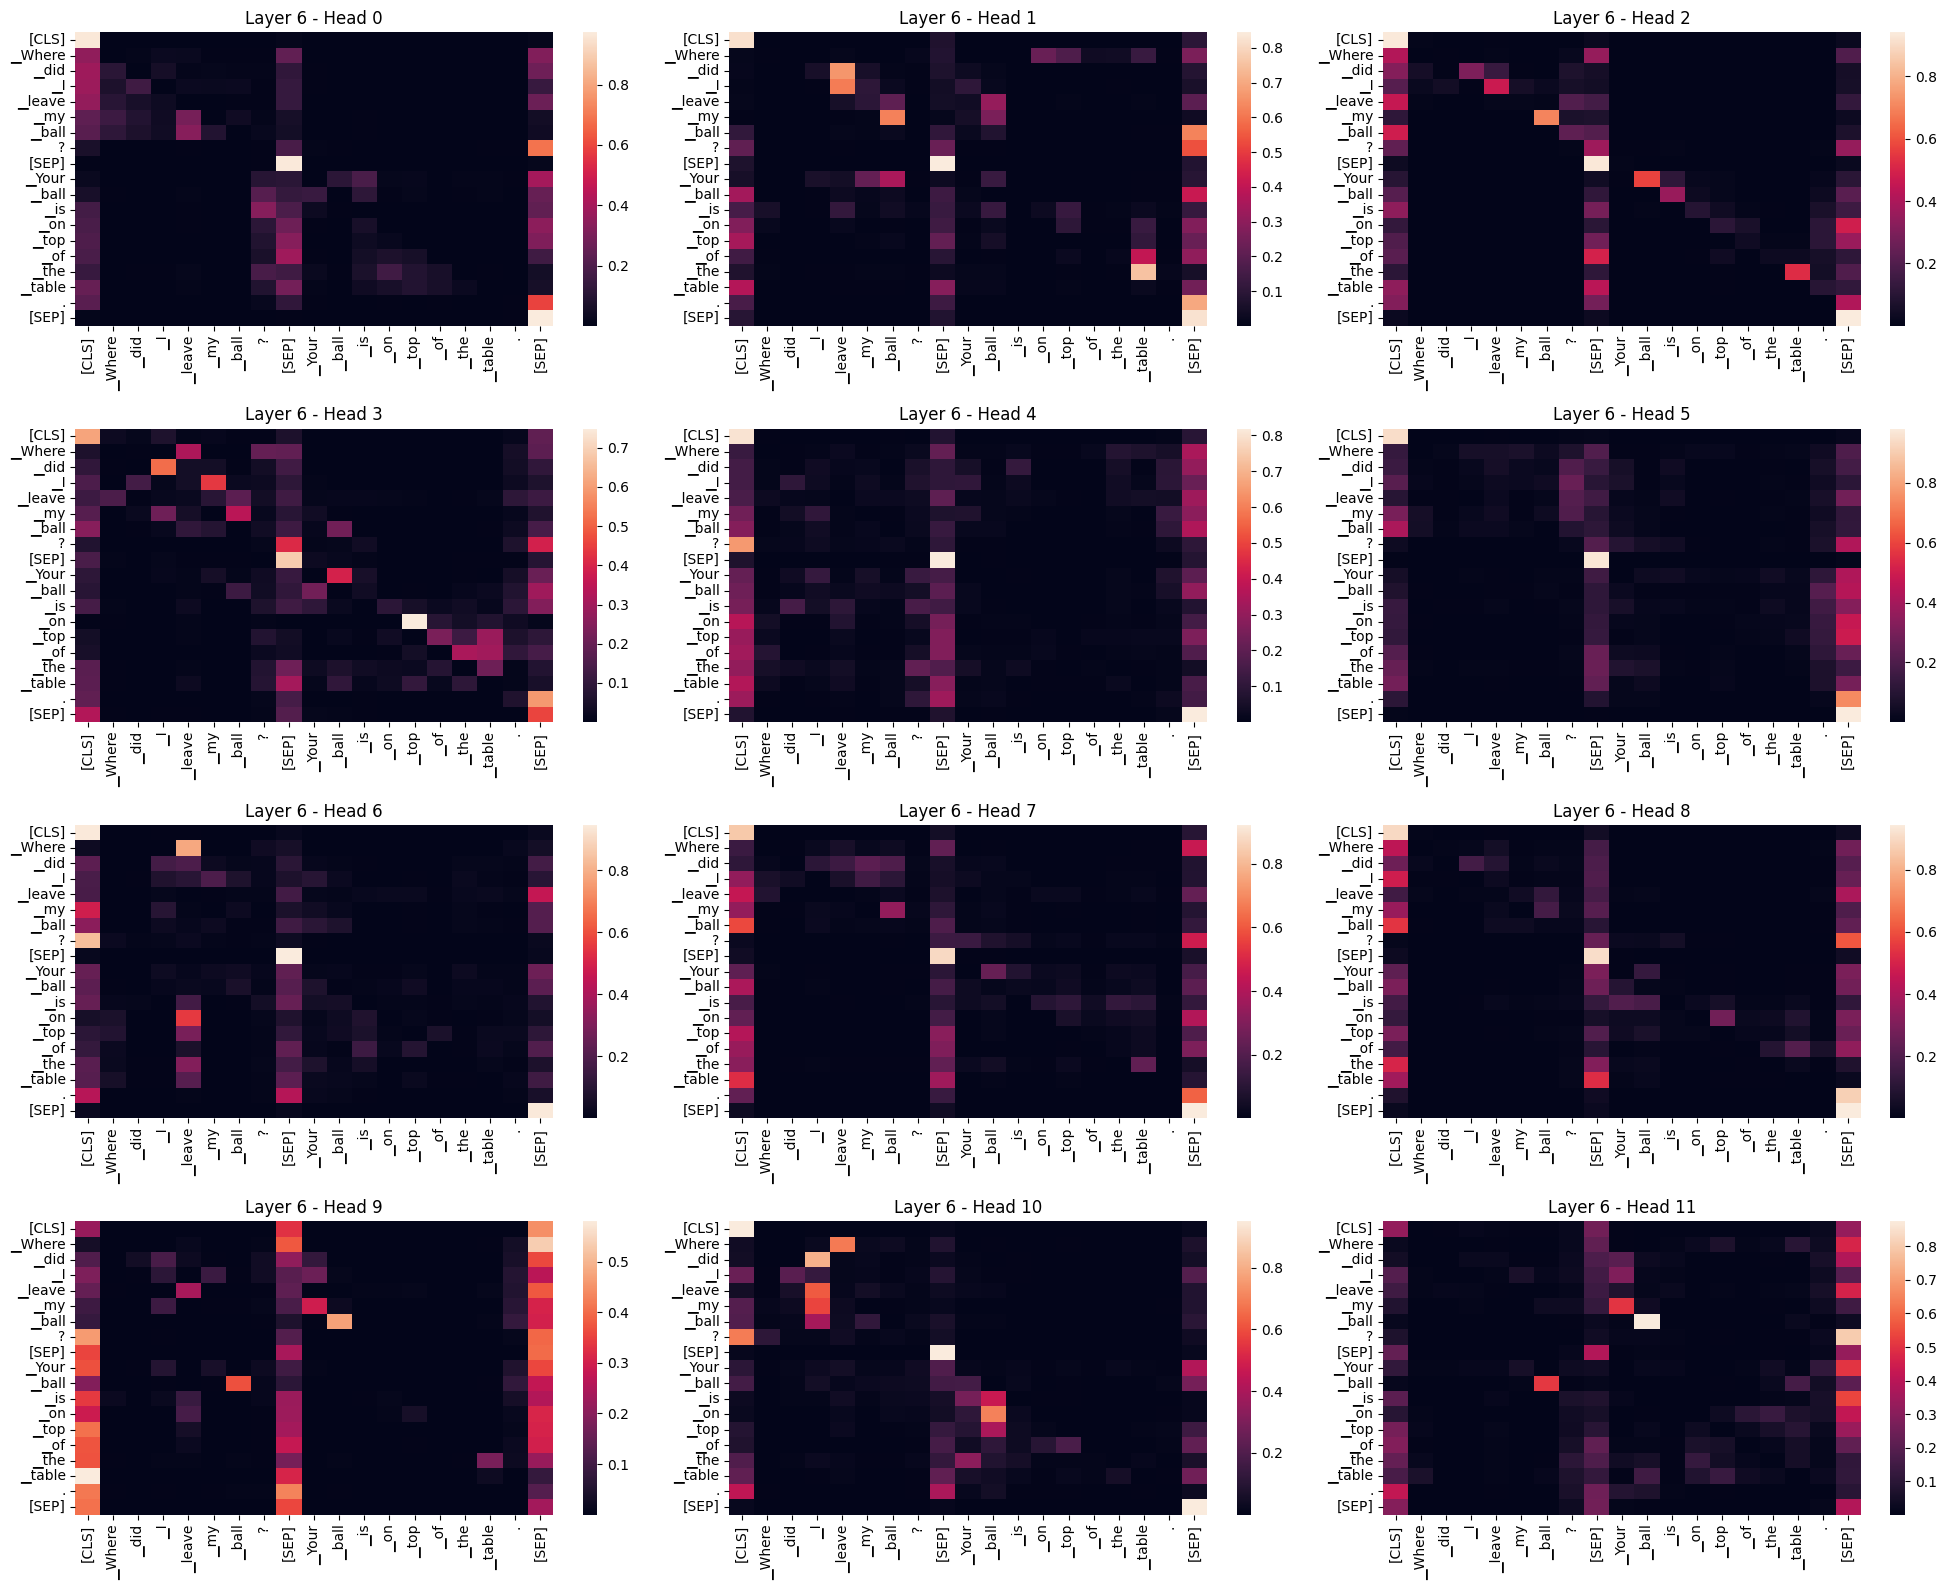

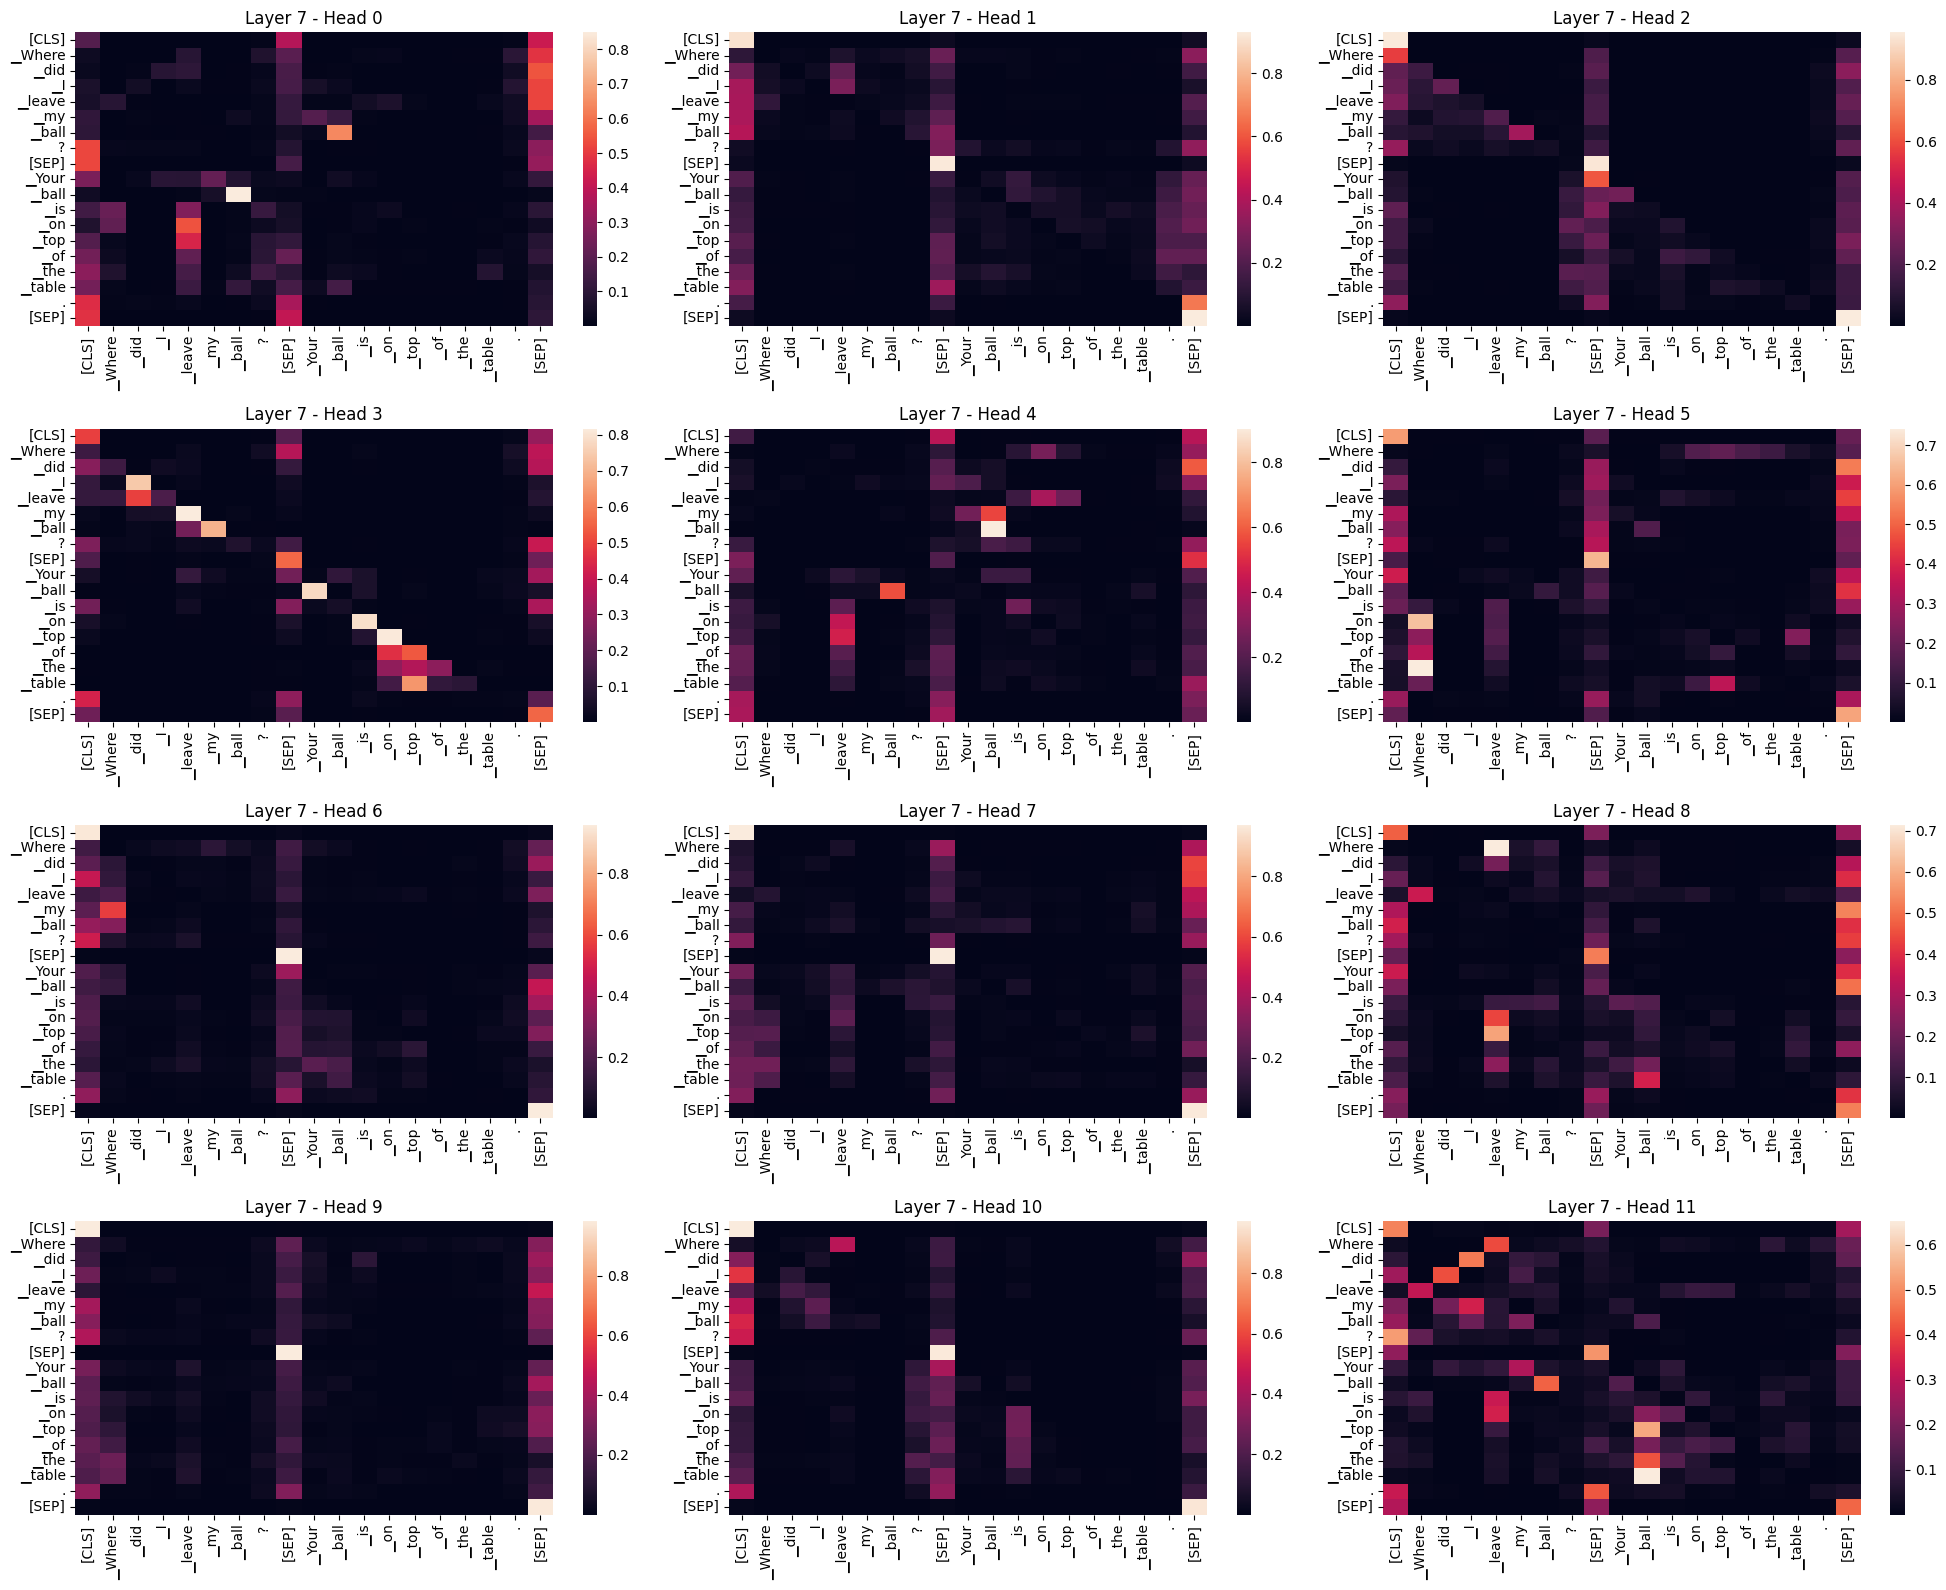

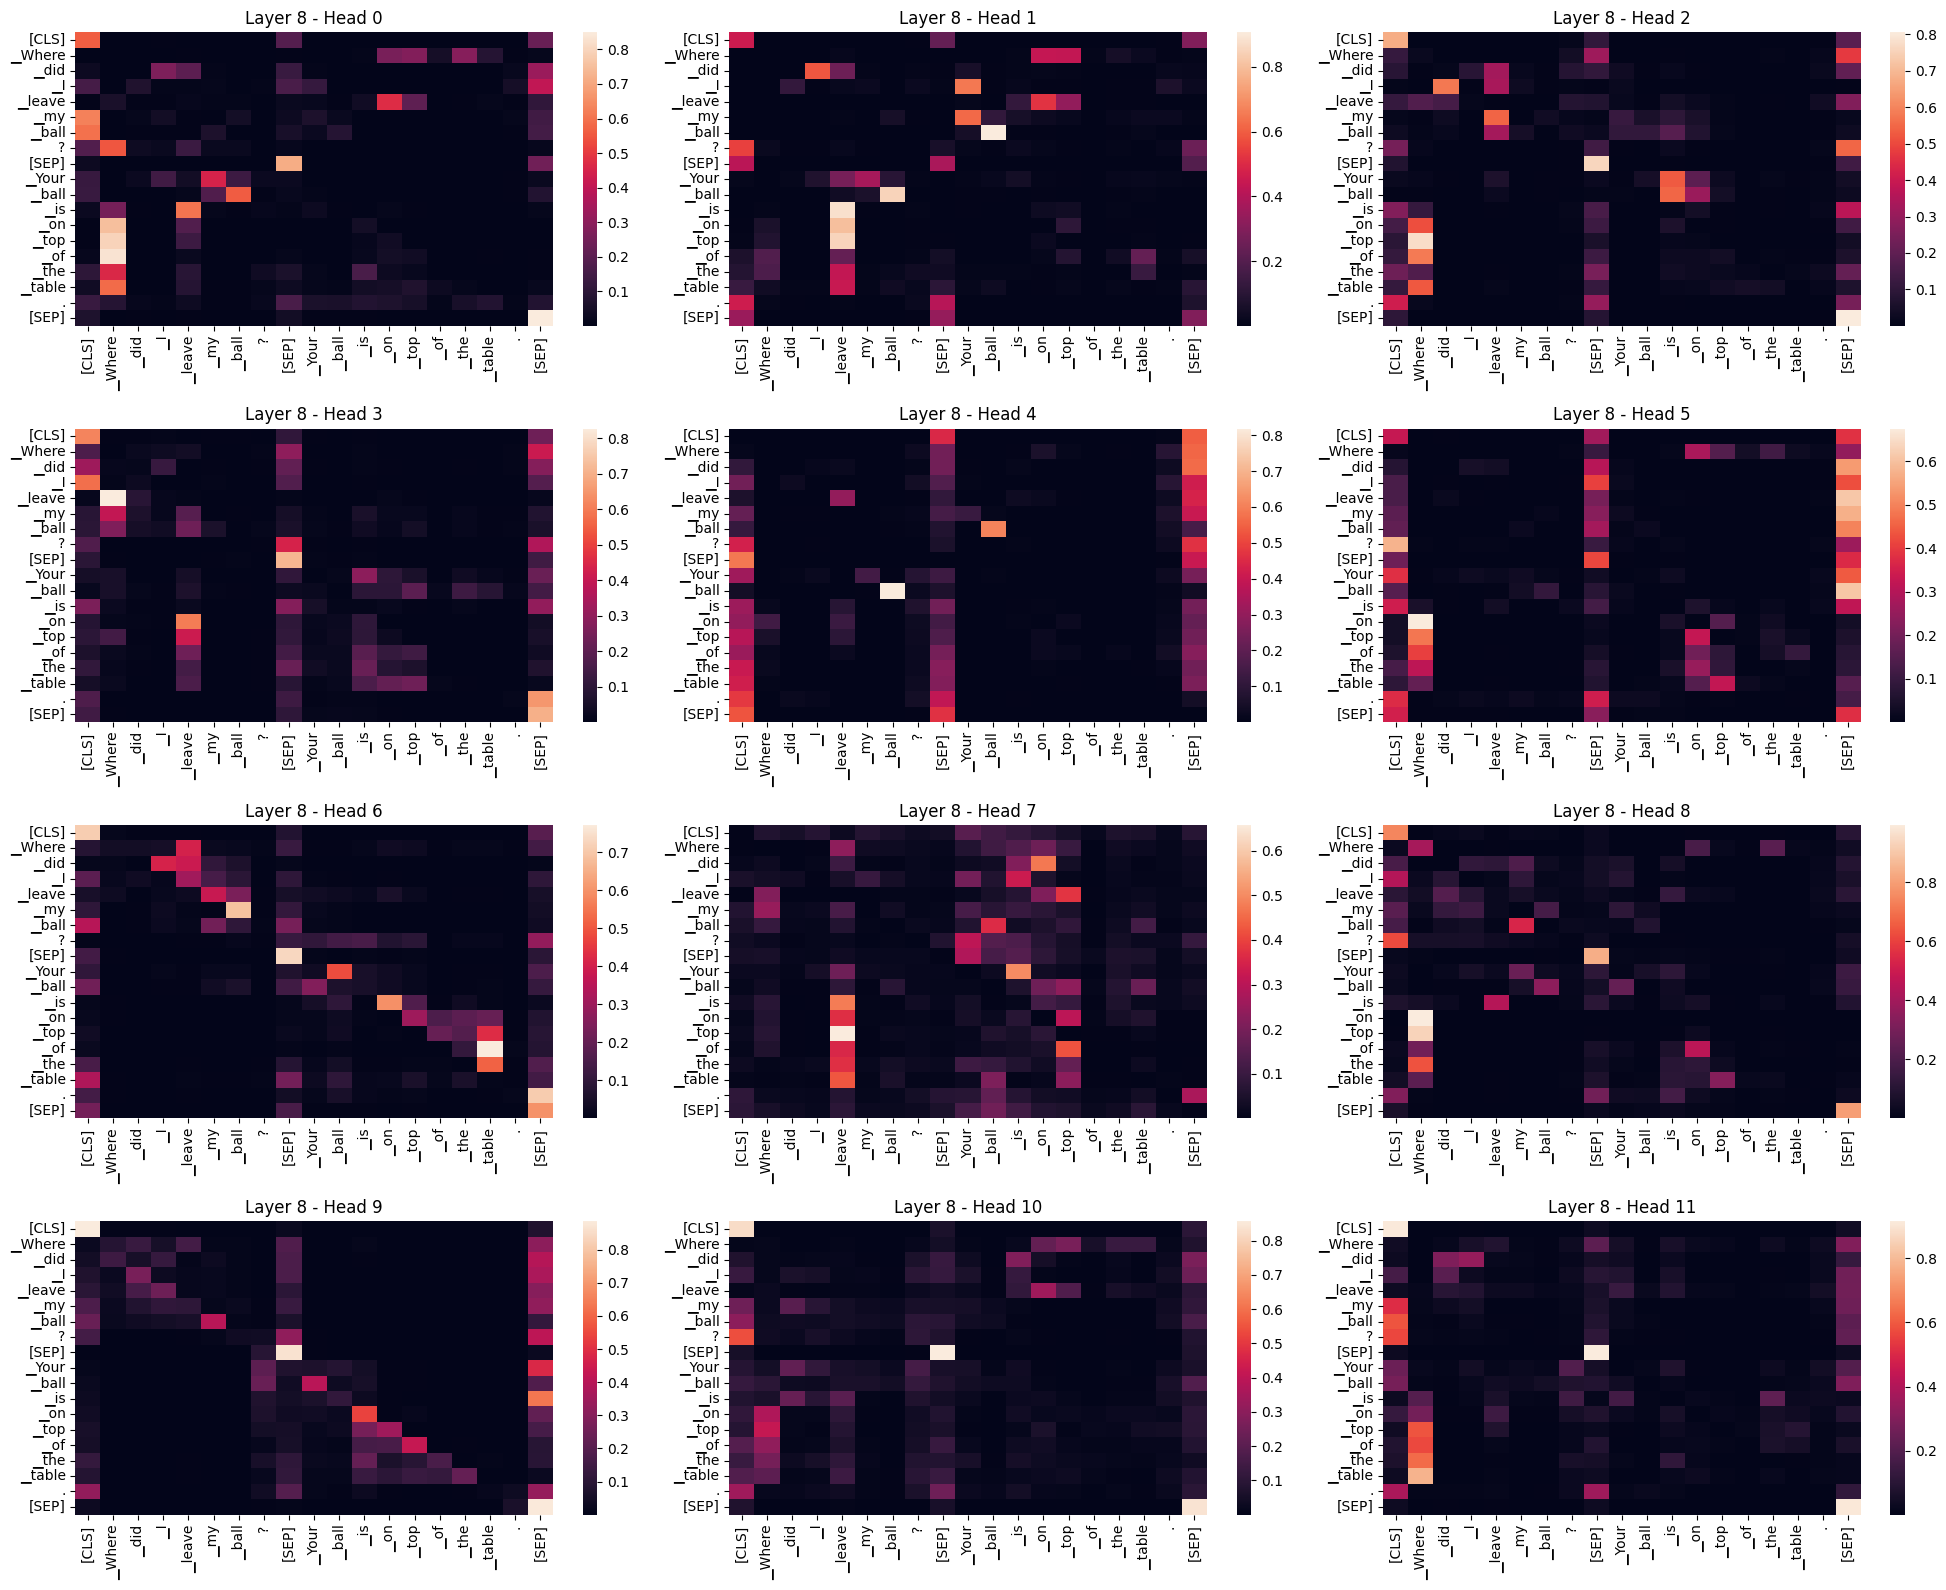

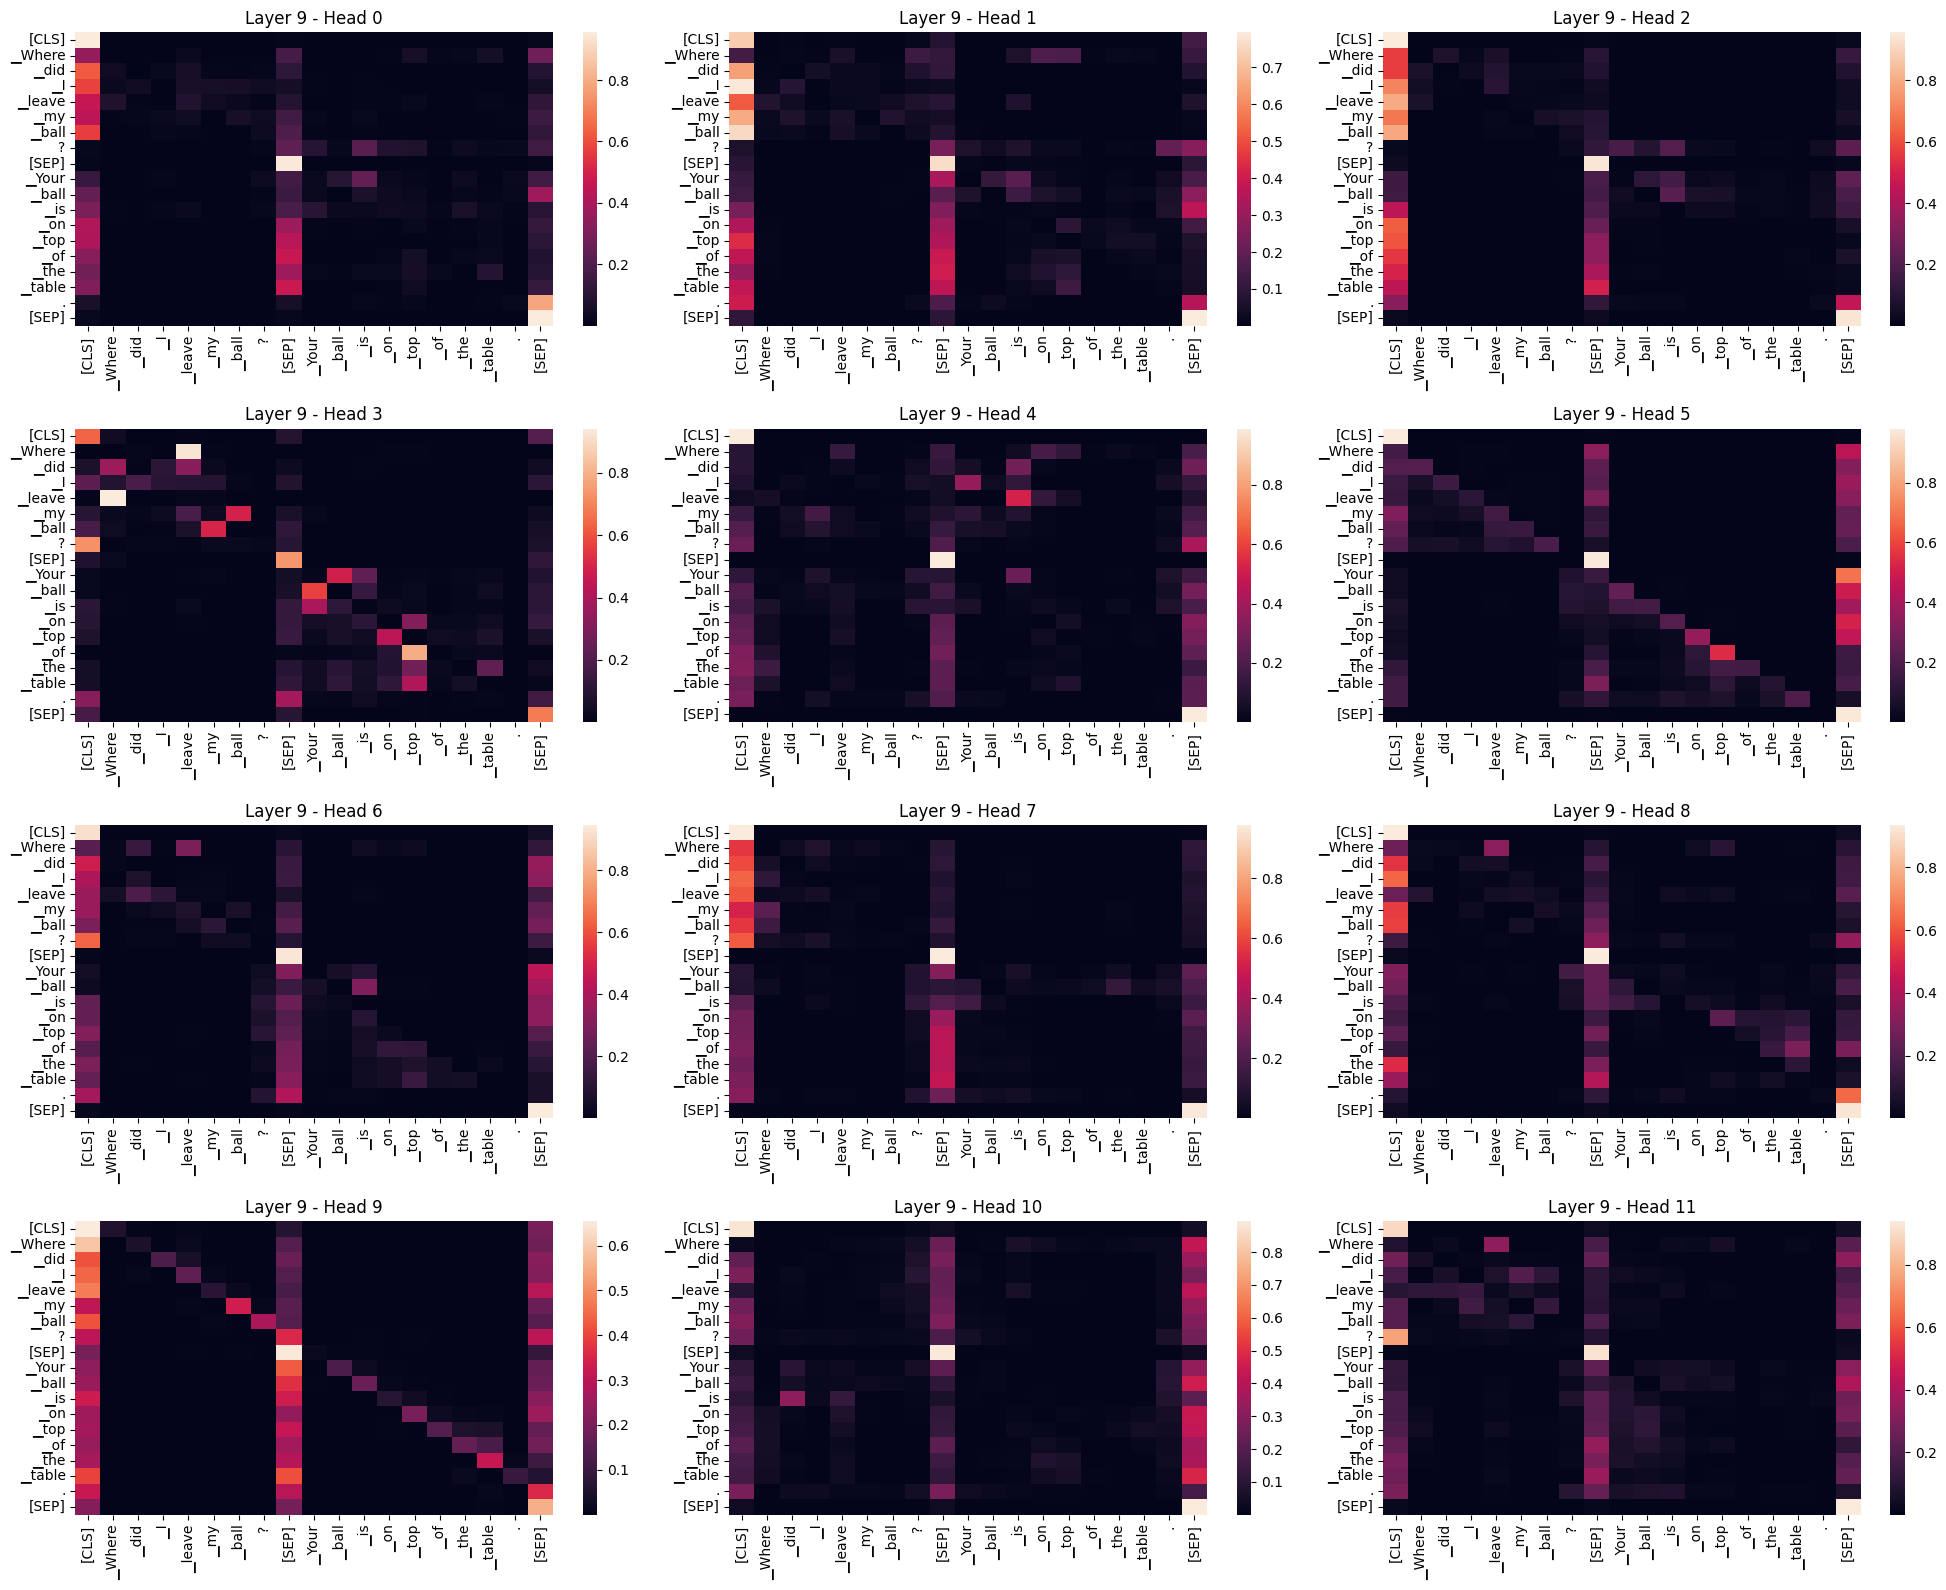

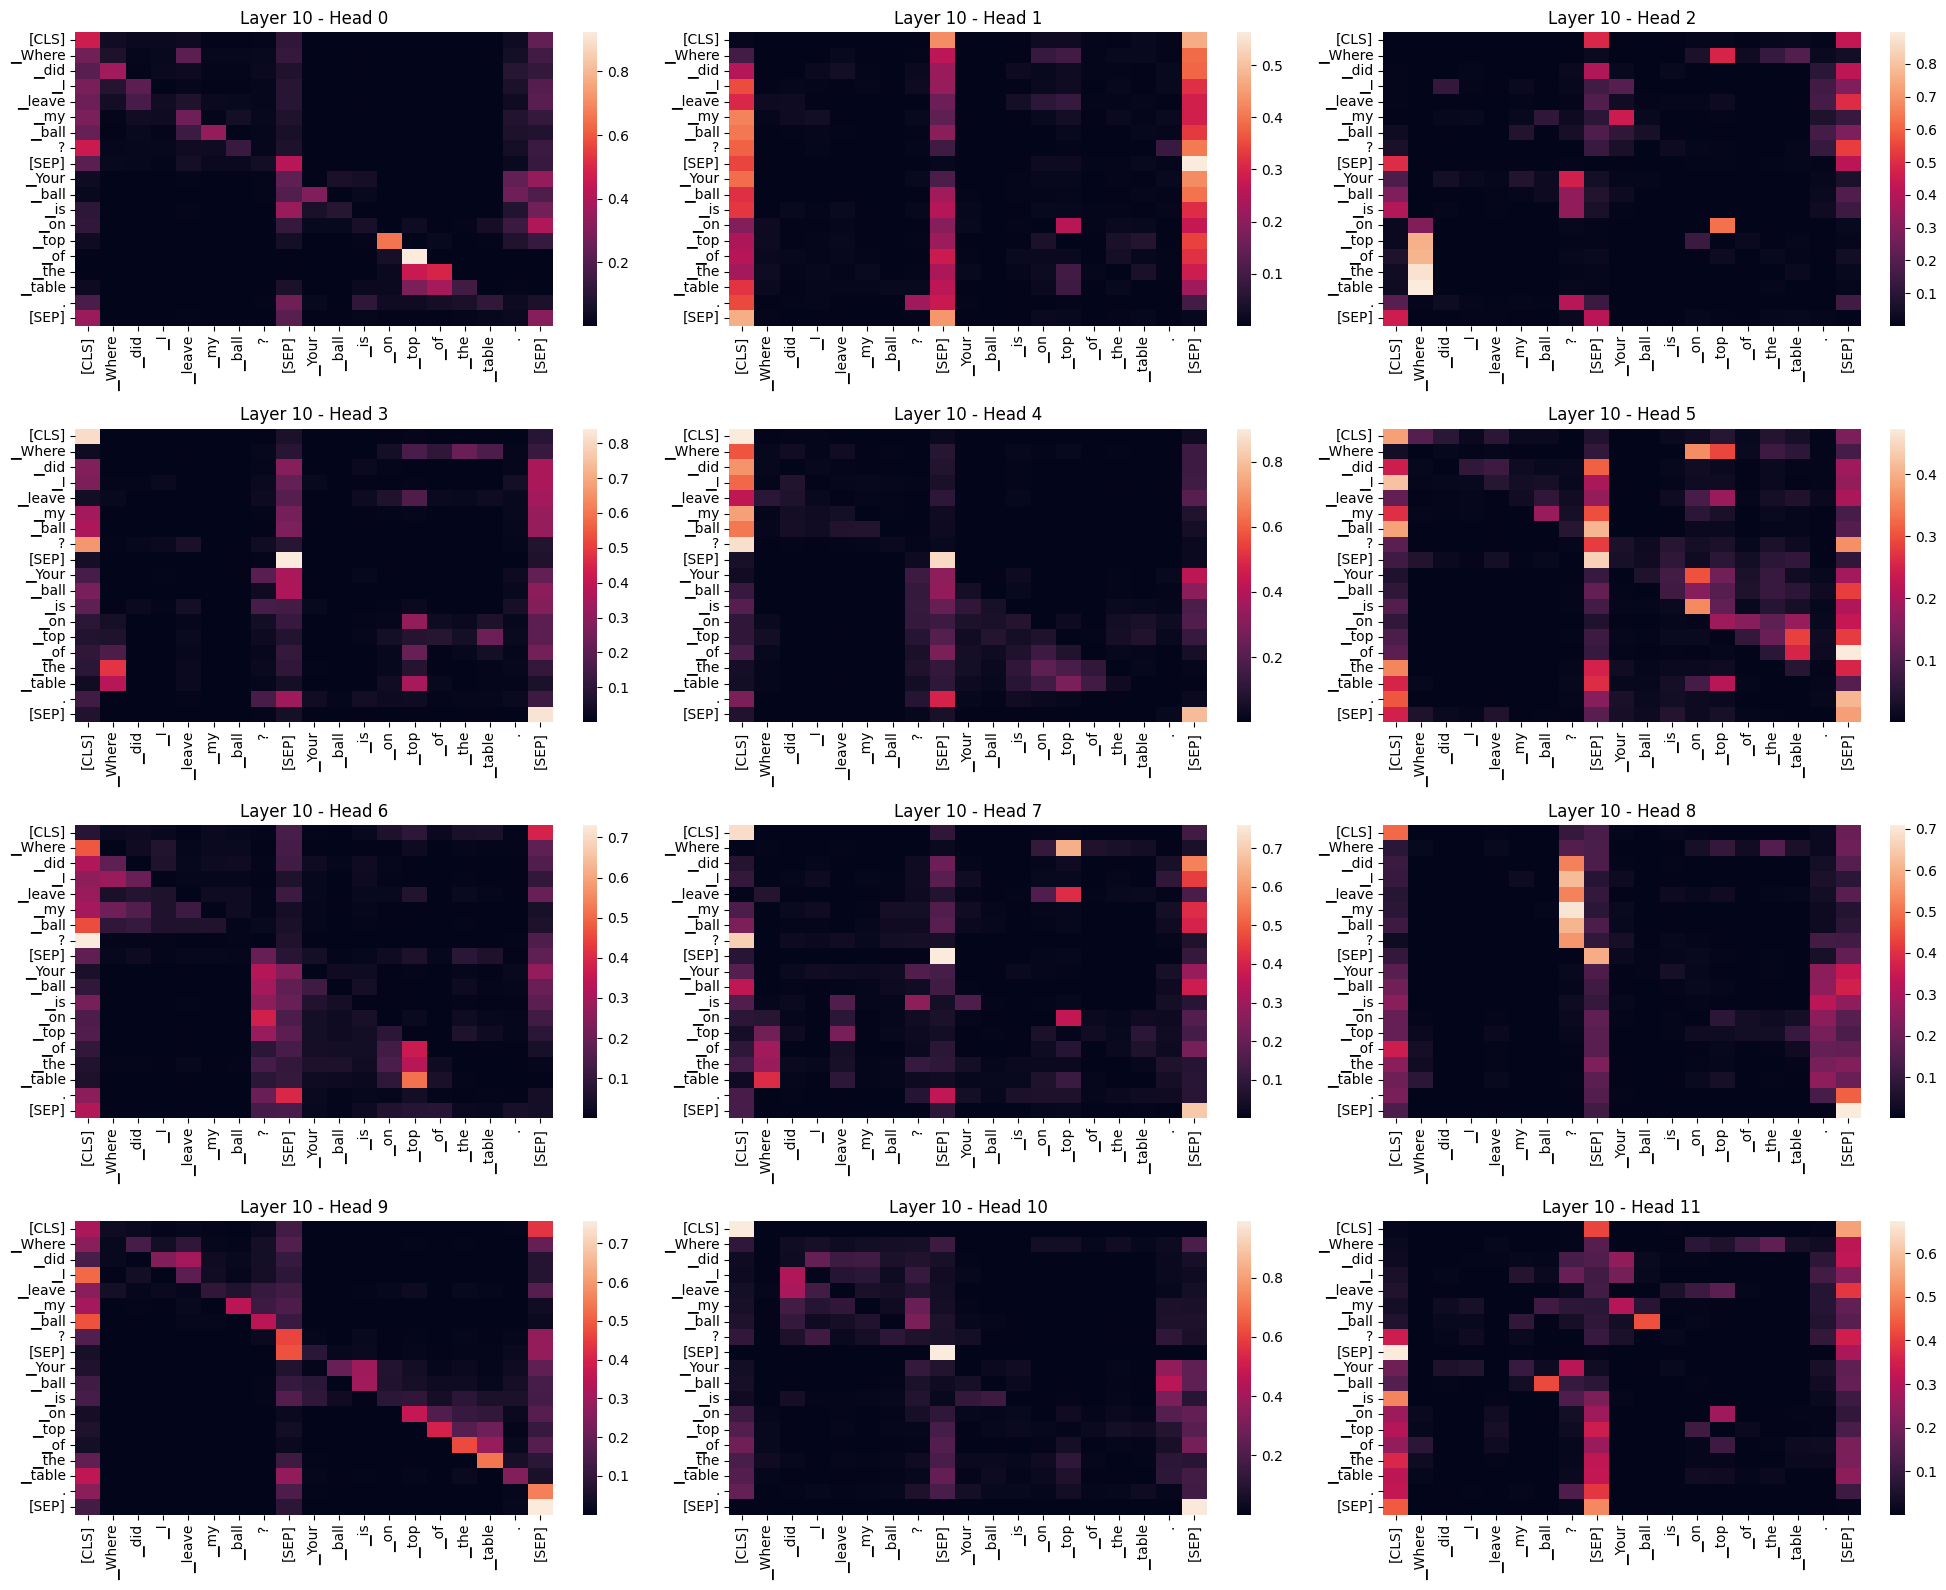

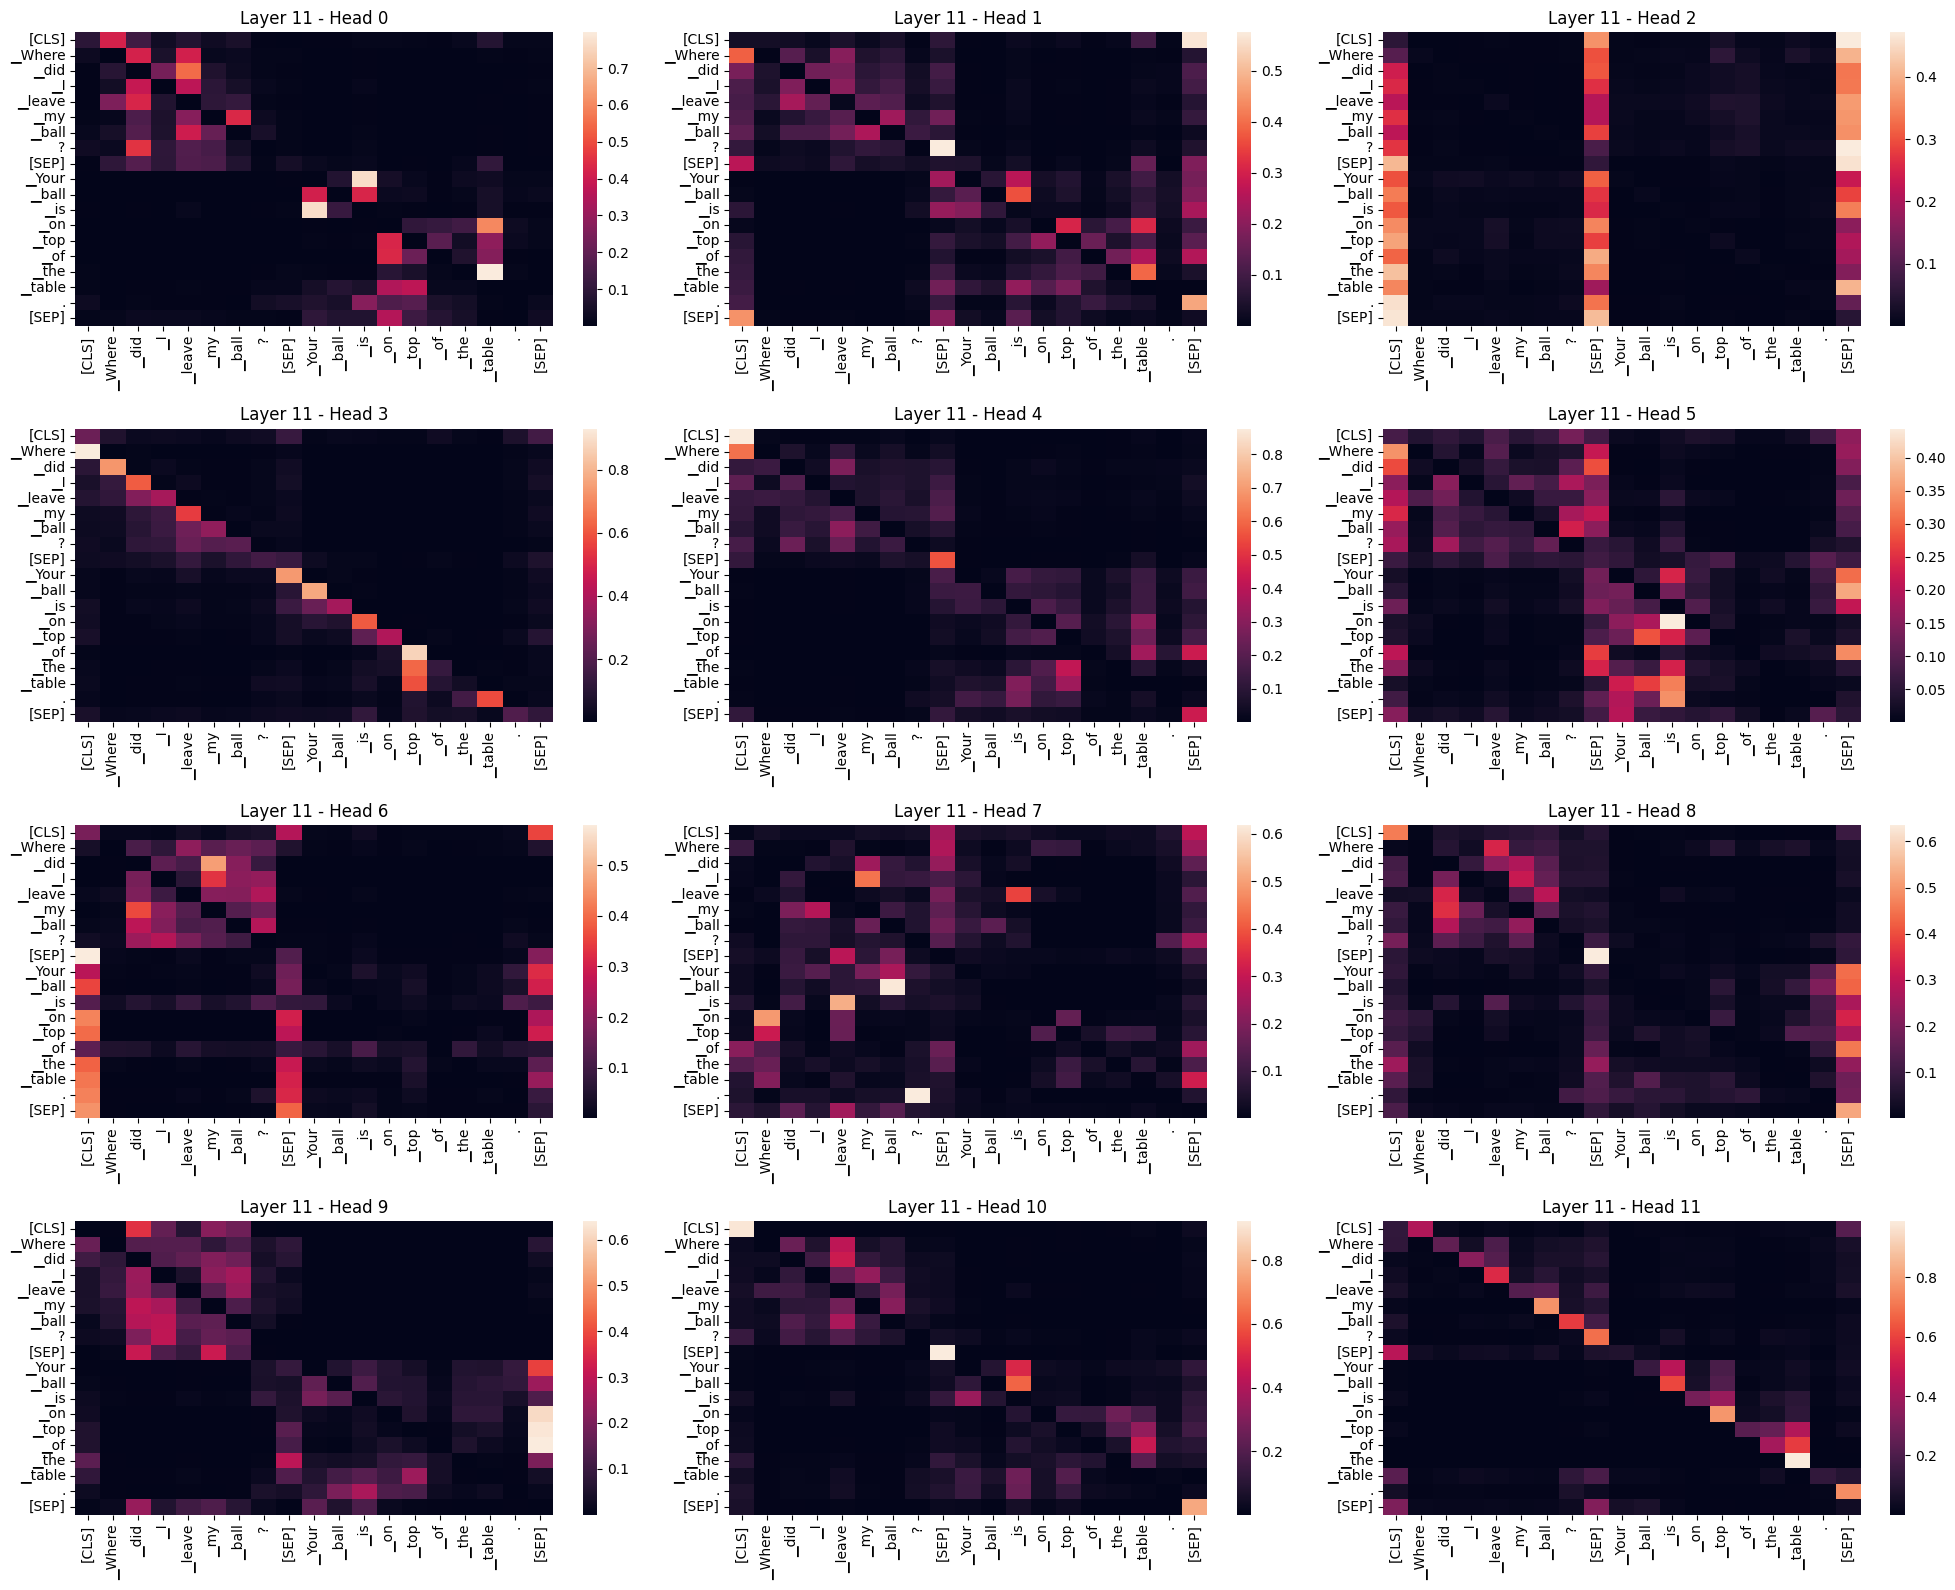

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(attention, tokens, num_heads, layer_num):
    # Set the size of the entire grid
    plt.figure(figsize=(20, 16))
    for head in range(num_heads):
        attention_head = attention[head].detach().numpy()
        ax = plt.subplot(4, 3, head+1)  # 4x3 grid for 12 heads
        sns.heatmap(attention_head, xticklabels=tokens, yticklabels=tokens, ax=ax)
        ax.set_title(f'Layer {layer_num} - Head {head}')
    plt.tight_layout()
    plt.show()

for layer_num in range(len(attentions)):
  attention_matrix = attentions[layer_num]
  num_heads = attention_matrix.size(1)

  # Ensure the number of tokens matches the attention matrix size
  tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[:attention_matrix.size(-1)]

  plot_attention(attention_matrix[0], tokens, num_heads, layer_num)